In [357]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

# Main Author: Branden Bulatao

In [358]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [359]:
# Import dataset
df = pd.read_csv("./dataset.csv")

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]

# Normalize data
# scalar = MinMaxScaler()
# X = pd.DataFrame(scalar.fit_transform(X), columns=X.columns)

# Identify numeric features to scale
numeric_features = [
    # "popularity",
    # "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    # "liveness",
    # "tempo",
]

numeric_high_value_features = [
    "popularity",
    "tempo",
    "loudness",
]

# All other features (binary or one-hot) are left as-is
non_scaled_features = [col for col in X.columns if col not in (numeric_features and numeric_high_value_features)]
# non_scaled_features = [col for col in X.columns if col not in numeric_high_value_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", MinMaxScaler(), numeric_features),
        ("num2", MinMaxScaler(), numeric_high_value_features),
        ("pass", "passthrough", non_scaled_features),
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
X_processed = pd.DataFrame(X_processed, columns=numeric_high_value_features + non_scaled_features)
# X_processed = pd.DataFrame(X_processed, columns=numeric_features + numeric_high_value_features + non_scaled_features)


# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

print(df.head(1))

target_train.head()
# attr_train.head()
target_test.head()

                 track_id      artists album_name track_name  popularity  \
0  5SuOikwiRyPMVoIQDJUgSV  Gen Hoshino     Comedy     Comedy          73   

   duration_ms  explicit  danceability  energy  loudness  ...  \
0       230666         0         0.676   0.461    -6.746  ...   

   track_genre_spanish  track_genre_study  track_genre_swedish  \
0                False              False                False   

   track_genre_synth-pop  track_genre_tango  track_genre_techno  \
0                  False              False               False   

   track_genre_trance  track_genre_trip-hop  track_genre_turkish  \
0               False                 False                False   

   track_genre_world-music  
0                    False  

[1 rows x 145 columns]


113186    0
42819     0
59311     0
90417     0
61000     1
Name: valence, dtype: int64

In [360]:
# K-nearest neighbors

k_values = [3, 5, 10]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # knn = KNeighborsClassifier(n_neighbors = k,weights='distance')
    knn.fit(attr_train, target_train)
    target_pred = knn.predict(attr_test)
    # accuracy = round(np.mean(target_test==target_pred ) * 100, 2)
    accuracy = accuracy_score(target_test, target_pred)
    print(f"Accuracy of model with k = {k}: {accuracy}")
    print("")

knn.n_features_in_

Accuracy of model with k = 3: 0.7286257309941521

Accuracy of model with k = 5: 0.728859649122807

Accuracy of model with k = 10: 0.7279824561403508



139

In [361]:
# Evaluate model
accuracy = accuracy_score(target_test, target_pred)
conf_matrix = confusion_matrix(target_test, target_pred)
class_report = classification_report(target_test, target_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

test_actual = attr_test  # Copy attr_test
test_actual["target_pred"] = target_pred  # Create new column for prediction values
test_actual["test_actual"] = target_test  # Create new column for actual values
test_actual.head()  # Show table

misclassified = (
    test_actual["target_pred"] != test_actual["test_actual"]
).sum()  # Calculate number of misclassified cases
total_tests = len(test_actual)  # total number of cases

error_rate = misclassified / total_tests

# Error rate percentage
print(f"Error rate: {error_rate:.2%}")

Accuracy: 0.7280

Confusion Matrix:
 [[14612  3959]
 [ 5344 10285]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76     18571
           1       0.72      0.66      0.69     15629

    accuracy                           0.73     34200
   macro avg       0.73      0.72      0.72     34200
weighted avg       0.73      0.73      0.73     34200

Error rate: 49.80%


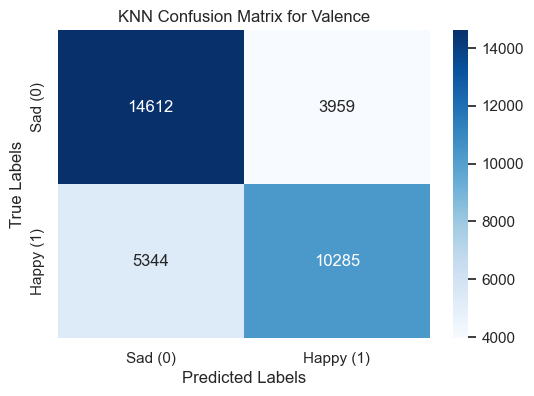

In [362]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(target_test, target_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("KNN Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()

In [363]:
# False positives
results = pd.DataFrame(X)  # make sure this matches your data

test_actual = attr_test  # Copy attr_test
test_actual["target_pred"] = target_pred  # Create new column for prediction values
test_actual["test_actual"] = target_test  # Create new column for actual values
# test_actual.head()  # Show table

false_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 0)
]

false_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 1)
]

true_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 1)
]

true_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 0)
]

print(false_positives)
print(false_negatives)
# false_positives.describe()

       popularity     tempo  loudness explicit danceability energy mode  \
88580         0.0  0.402495  0.817343        0        0.786  0.696    0   
60735        0.19  0.497177    0.6857        0        0.911  0.616    1   
20362        0.74  0.410853  0.797274        0        0.653  0.658    1   
37587        0.48  0.626983  0.819877        0        0.553  0.732    0   
7020         0.33  0.430025  0.750347        0        0.472  0.702    1   
...           ...       ...       ...      ...          ...    ...  ...   
53279         0.0   0.51743  0.774467        0        0.578  0.854    0   
84333        0.56  0.421404  0.642473        0        0.653  0.472    1   
103113        0.0  0.412471  0.756969        0        0.637  0.745    1   
53782        0.62  0.369648  0.891349        1        0.687  0.915    1   
41890         0.2  0.502252  0.739008        0        0.362  0.668    1   

       speechiness acousticness instrumentalness  ... track_genre_swedish  \
88580        0.352    

In [364]:
# # Code given from the ML02_EDA.ipynb
# # Summarize each column
# summary_p = false_positives.describe().loc[["min", "max", "mean"]]
# summary_n = false_negatives.describe().loc[["min", "max", "mean"]]

# # Print the summary
# print(summary_p)
# print(summary_n)

# print("\n min, max, mean only")
# # Min_Max_Mean=df.describe(include=[float, int]).loc[["min", "max", "mean"]]
# Min_Max_Mean = X.describe(include=[float, int]).loc[["min", "max", "mean"]]
# print(Min_Max_Mean)

In [365]:
# print("False Negatives Summary vs Full Dataset:")
# print(false_negatives.describe().loc[["mean"]])
# print("\nFull Dataset:")
# print(df.describe().loc[["mean"]])

# delta_n = false_negatives.describe().loc["mean"] - df.describe().loc["mean"]
# print("\nDifference in Mean (False Negatives - Full Dataset):")
# print(delta_n)

# delta_p = false_positives.describe().loc["mean"] - df.describe().loc["mean"]
# print("\nDifference in Mean (False Positives - Full Dataset):")
# print(delta_p)

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')


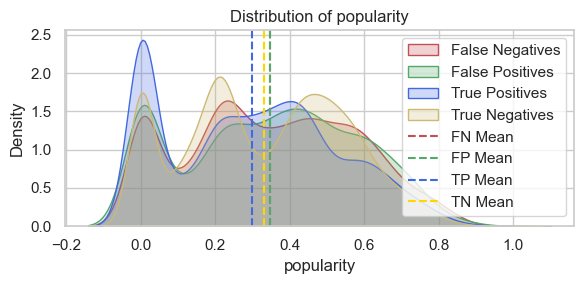

<class 'numpy.float64'>
Stats for 'popularity':
  False Negatives - mean: 0.3477, std: 0.2264
  False Positives - mean: 0.3472, std: 0.2321
  True Positives  - mean: 0.2982, std: 0.2257
  True Negatives  - mean: 0.3295, std: 0.2152
------------------------------------------------------------


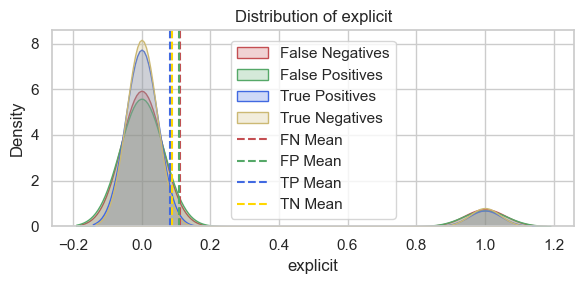

<class 'numpy.float64'>
Stats for 'explicit':
  False Negatives - mean: 0.1120, std: 0.3154
  False Positives - mean: 0.1097, std: 0.3126
  True Positives  - mean: 0.0817, std: 0.2740
  True Negatives  - mean: 0.0886, std: 0.2841
------------------------------------------------------------


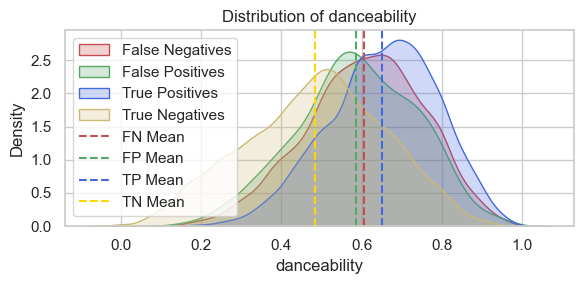

<class 'numpy.float64'>
Stats for 'danceability':
  False Negatives - mean: 0.6063, std: 0.1473
  False Positives - mean: 0.5864, std: 0.1513
  True Positives  - mean: 0.6519, std: 0.1369
  True Negatives  - mean: 0.4845, std: 0.1752
------------------------------------------------------------


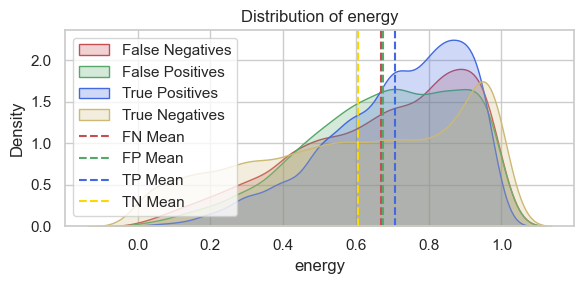

<class 'numpy.float64'>
Stats for 'energy':
  False Negatives - mean: 0.6692, std: 0.2315
  False Positives - mean: 0.6741, std: 0.2129
  True Positives  - mean: 0.7087, std: 0.1907
  True Negatives  - mean: 0.6057, std: 0.2890
------------------------------------------------------------


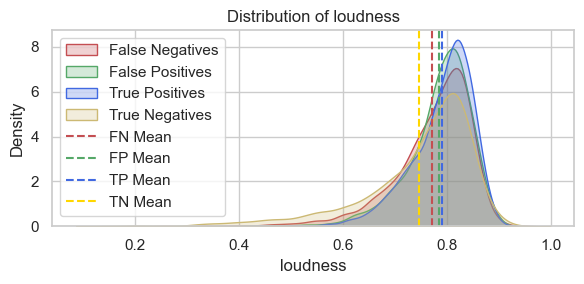

<class 'numpy.float64'>
Stats for 'loudness':
  False Negatives - mean: 0.7719, std: 0.0772
  False Positives - mean: 0.7844, std: 0.0641
  True Positives  - mean: 0.7904, std: 0.0610
  True Negatives  - mean: 0.7461, std: 0.1094
------------------------------------------------------------


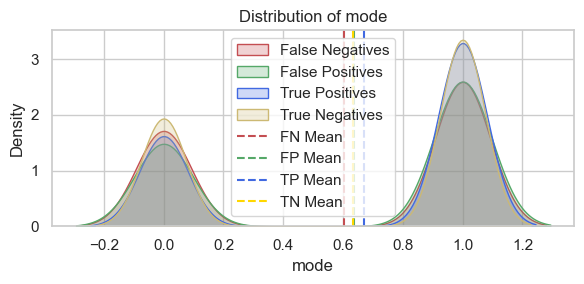

<class 'numpy.float64'>
Stats for 'mode':
  False Negatives - mean: 0.6023, std: 0.4895
  False Positives - mean: 0.6370, std: 0.4809
  True Positives  - mean: 0.6702, std: 0.4702
  True Negatives  - mean: 0.6338, std: 0.4818
------------------------------------------------------------


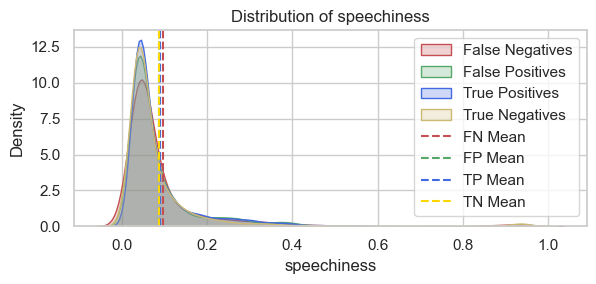

<class 'numpy.float64'>
Stats for 'speechiness':
  False Negatives - mean: 0.0962, std: 0.1325
  False Positives - mean: 0.0860, std: 0.0957
  True Positives  - mean: 0.0881, std: 0.0963
  True Negatives  - mean: 0.0869, std: 0.1253
------------------------------------------------------------


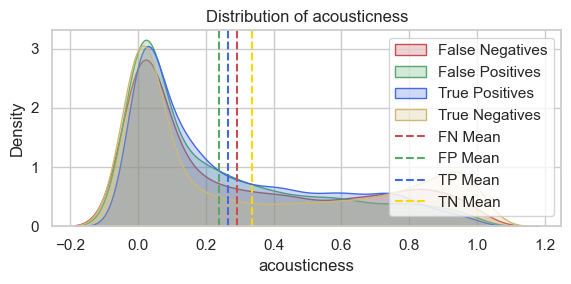

<class 'numpy.float64'>
Stats for 'acousticness':
  False Negatives - mean: 0.2931, std: 0.3230
  False Positives - mean: 0.2407, std: 0.2779
  True Positives  - mean: 0.2655, std: 0.2750
  True Negatives  - mean: 0.3367, std: 0.3685
------------------------------------------------------------


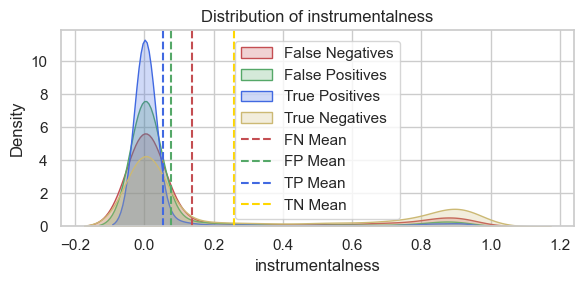

<class 'numpy.float64'>
Stats for 'instrumentalness':
  False Negatives - mean: 0.1386, std: 0.2897
  False Positives - mean: 0.0783, std: 0.2153
  True Positives  - mean: 0.0527, std: 0.1791
  True Negatives  - mean: 0.2595, std: 0.3701
------------------------------------------------------------


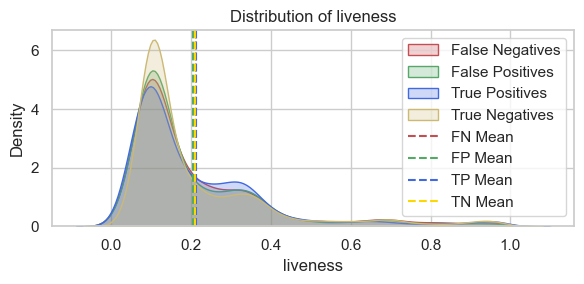

<class 'numpy.float64'>
Stats for 'liveness':
  False Negatives - mean: 0.2122, std: 0.1845
  False Positives - mean: 0.2054, std: 0.1772
  True Positives  - mean: 0.2121, std: 0.1834
  True Negatives  - mean: 0.2105, std: 0.1855
------------------------------------------------------------


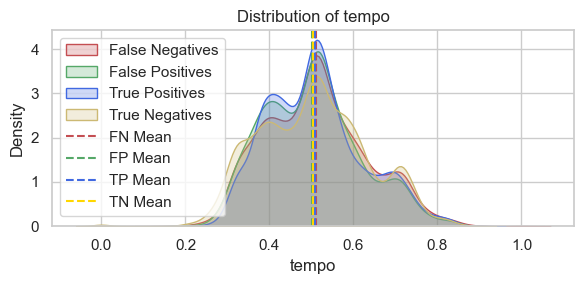

<class 'numpy.float64'>
Stats for 'tempo':
  False Negatives - mean: 0.5104, std: 0.1209
  False Positives - mean: 0.5005, std: 0.1152
  True Positives  - mean: 0.5073, std: 0.1142
  True Negatives  - mean: 0.5032, std: 0.1287
------------------------------------------------------------


In [403]:
import seaborn as sns
import matplotlib.pyplot as plt

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
    ]
]

# KF_df = df.drop(columns=["valence","duration_ms"])
print(df_no_genres.select_dtypes(include=["float", "int"]).columns)
for col in df_no_genres.select_dtypes(include=["float", "int"]).columns:
    if col == "valence" or col == "duration_ms": continue
   
    plt.figure(figsize=(6, 3))

    # KDE plots
    sns.kdeplot(false_negatives[col], label="False Negatives", fill=True, color="r")
    sns.kdeplot(false_positives[col], label="False Positives", fill=True, color="g")
    sns.kdeplot(true_positives[col], label="True Positives", fill=True, color="royalblue")
    sns.kdeplot(true_negatives[col], label="True Negatives", fill=True, color="y")

    # Vertical lines for means
    plt.axvline(false_negatives[col].mean(), color="r", linestyle="--", label="FN Mean")
    plt.axvline(false_positives[col].mean(), color="g", linestyle="--", label="FP Mean")
    plt.axvline(
        true_positives[col].mean(), color="royalblue", linestyle="--", label="TP Mean"
    )
    plt.axvline(
        true_negatives[col].mean(), color="gold", linestyle="--", label="TN Mean"
    )

    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(type(false_negatives[col].mean()))

    print(f"Stats for '{col}':")
    print(f"  False Negatives - mean: {false_negatives[col].mean():.4f}, std: {false_negatives[col].std():.4f}")
    print(f"  False Positives - mean: {false_positives[col].mean():.4f}, std: {false_positives[col].std():.4f}")
    print(f"  True Positives  - mean: {true_positives[col].mean():.4f}, std: {true_positives[col].std():.4f}")
    print(f"  True Negatives  - mean: {true_negatives[col].mean():.4f}, std: {true_negatives[col].std():.4f}")
    print("-" * 60)

['popularity', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']


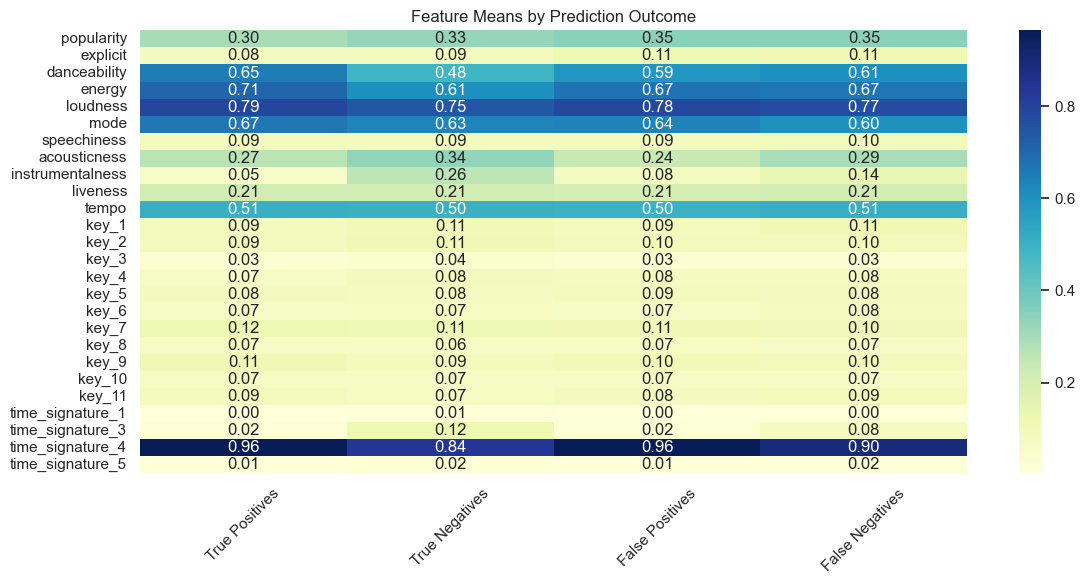

instrumentalness std deviation:  0.09214853002930391


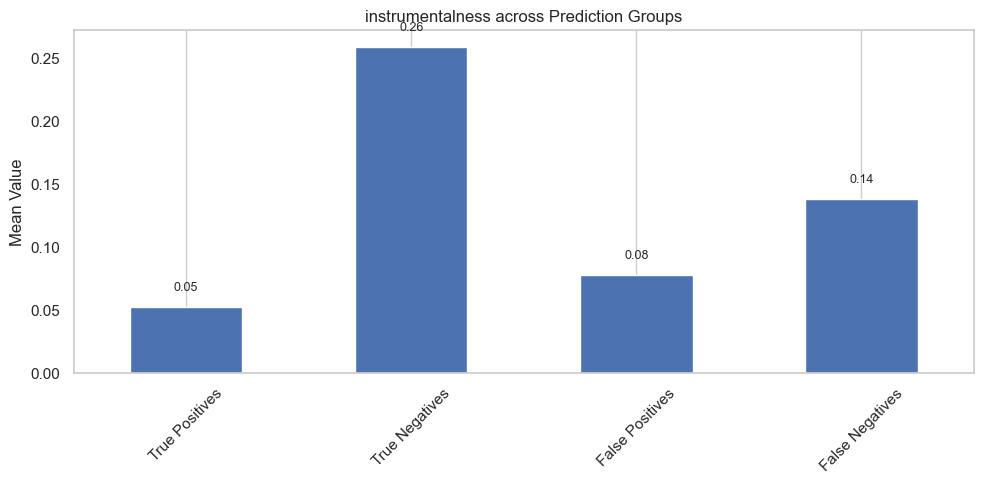

danceability std deviation:  0.07072429453632618


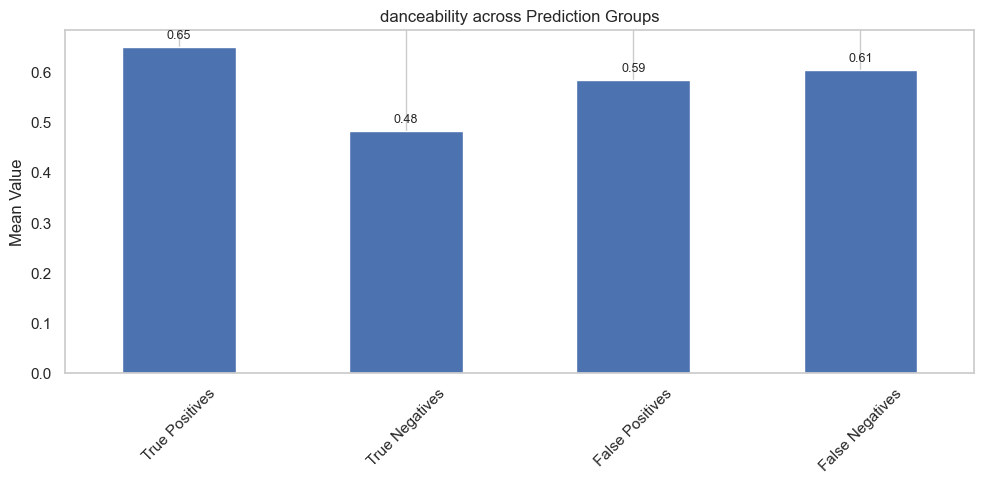

time_signature_4 std deviation:  0.06023379316752906


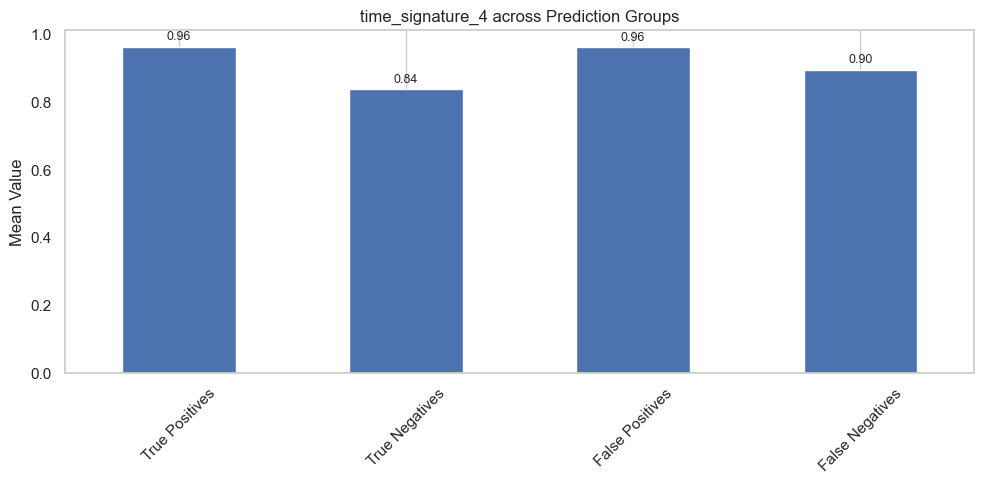

time_signature_3 std deviation:  0.0503297353905897


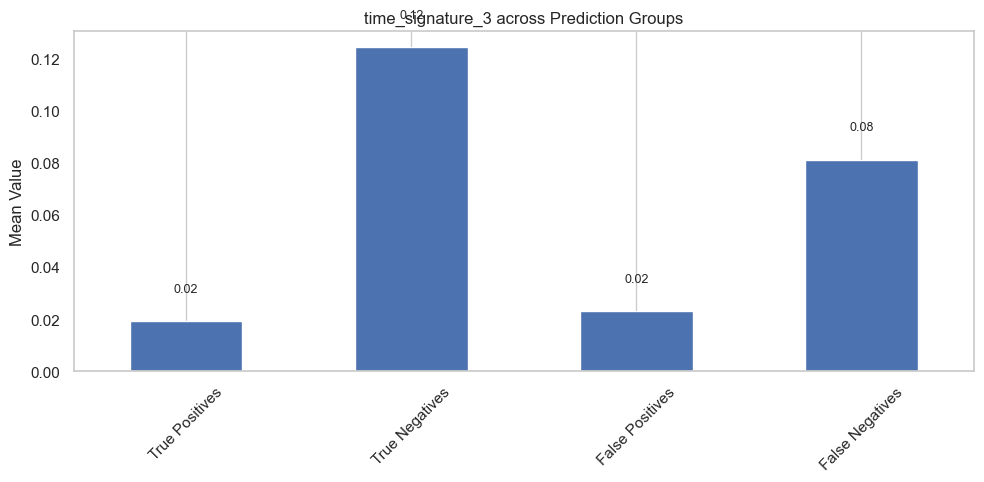

energy std deviation:  0.042908543484336974


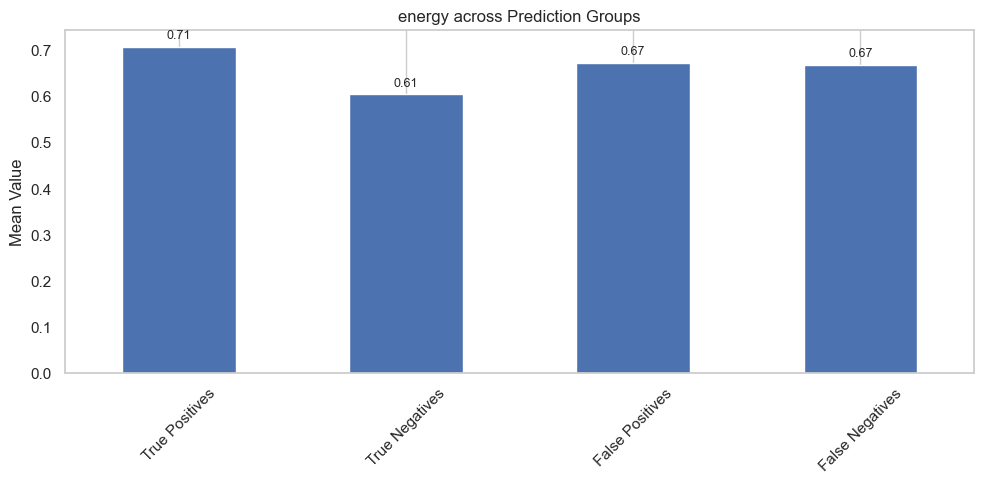

acousticness std deviation:  0.04113528307799


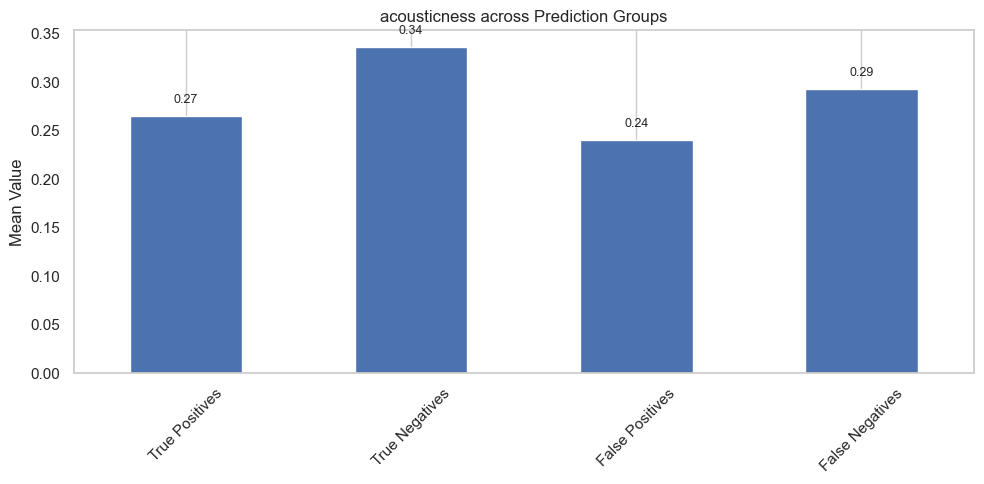

mode std deviation:  0.027765470893364244


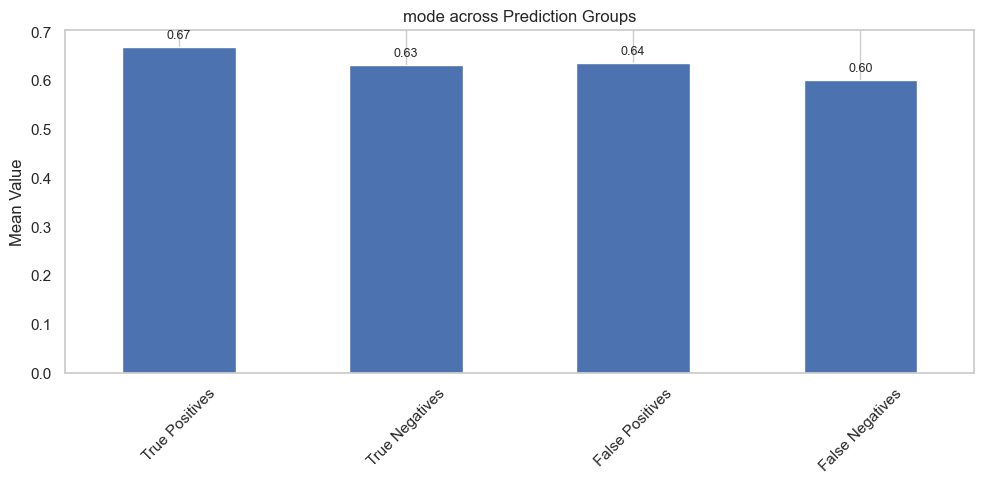

popularity std deviation:  0.02324478017783087


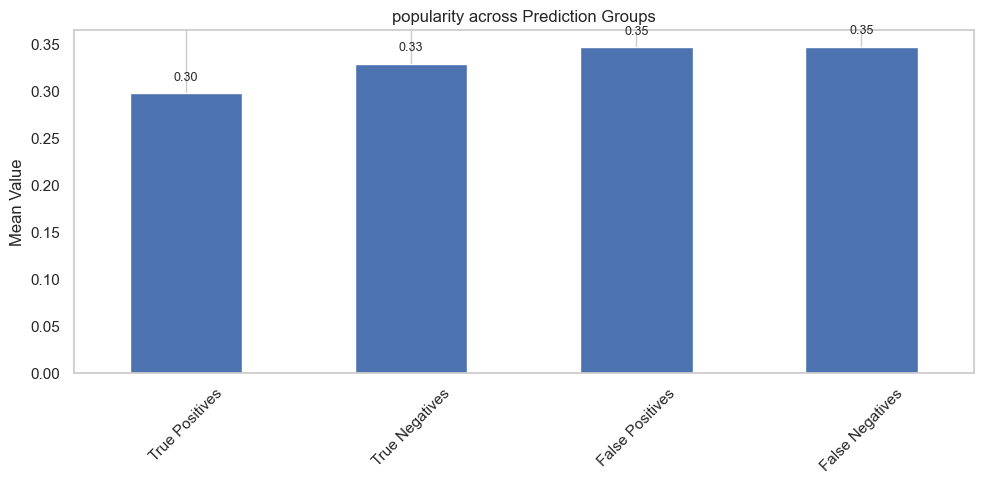

loudness std deviation:  0.019649681945681993


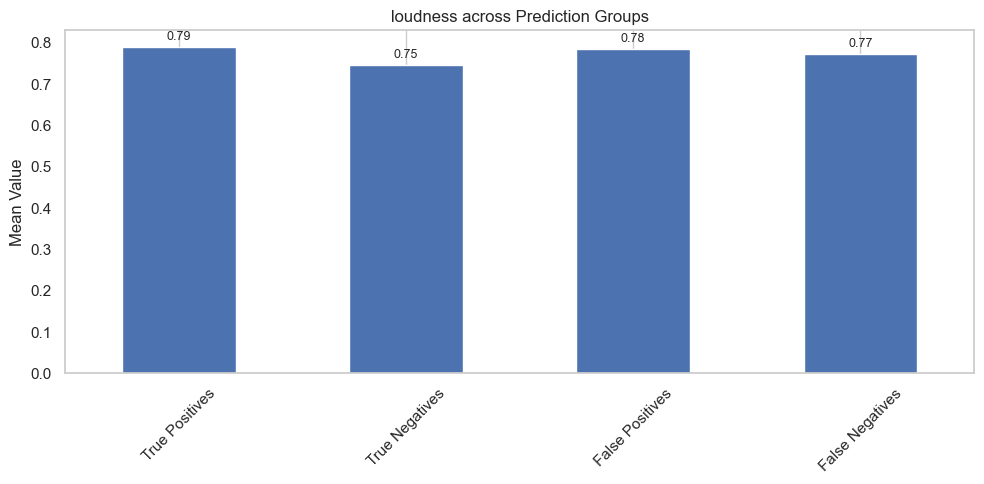

explicit std deviation:  0.015117478634560859


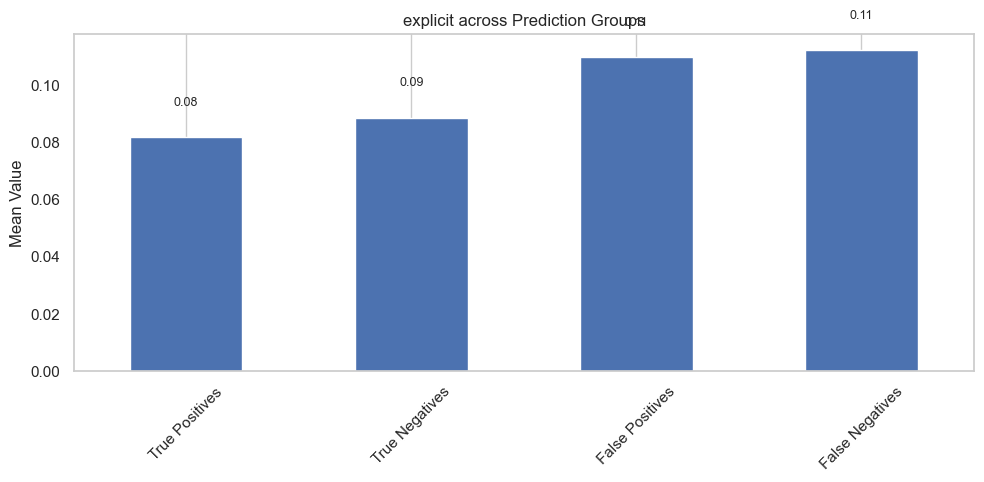

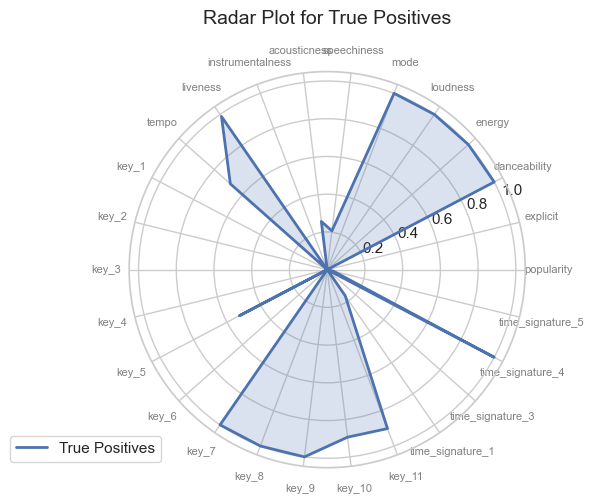

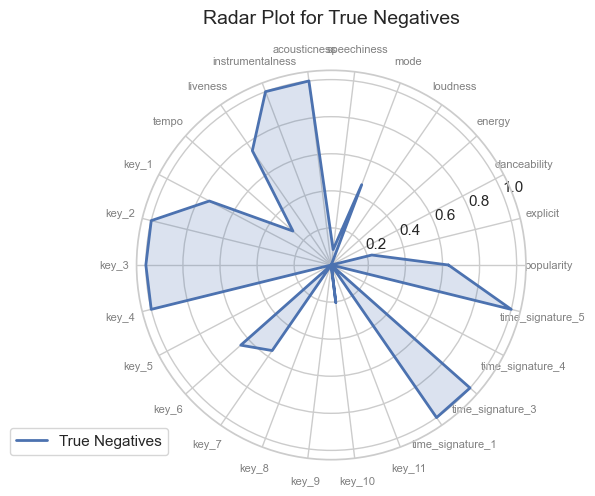

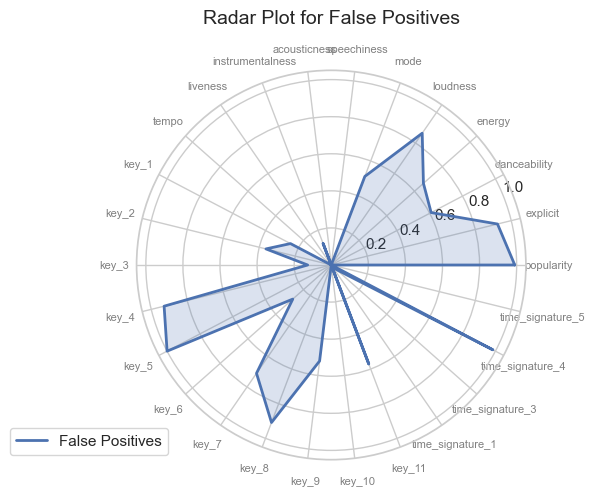

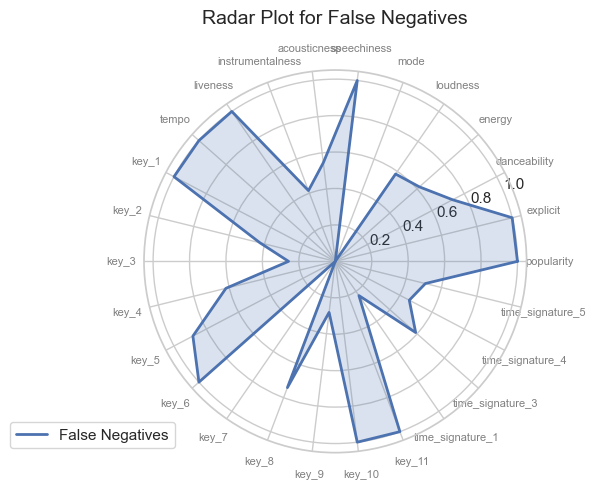

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# Features only (adjust as needed)
feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
        "duration_ms"
    ]
]

print(feature_cols)

# Mean summary per category
summary_df = pd.DataFrame(
    {
        "True Positives": true_positives[feature_cols].mean(),
        "True Negatives": true_negatives[feature_cols].mean(),
        "False Positives": false_positives[feature_cols].mean(),
        "False Negatives": false_negatives[feature_cols].mean(),
        # "All Data": df[feature_cols].mean(),
    }
)

# Transpose for easier plotting
summary_df = summary_df.astype(float)
summary_df = summary_df.T

# Optional: Normalize columns for radar/spider-style plots
summary_norm = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())

# --- Plot 1: Heatmap of Means per Outcome Type ---
plt.figure(figsize=(12, 6))
sns.heatmap(summary_df.T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Feature Means by Prediction Outcome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 2: Comparison Bar Plot for One Feature at a Time ---
# Choose top 5 most differing features (by std deviation across groups)
top_diff_features = summary_df.std().sort_values(ascending=False).head(10).index

for feature in top_diff_features:
    print(feature + ' std deviation: ', summary_df[feature].std())
    
    ax = summary_df[feature].plot(
        kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
    )

    # Add value labels above each bar
    for i, value in enumerate(summary_df[feature]):
        ax.text(i, value + 0.01, f"{value:.2f}", ha="center", va="bottom", fontsize=9)
        
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# --- Plot 3: Radar Plot (optional, fancier) ---
try:
    from math import pi

    categories = list(summary_norm.columns)
    groups = summary_norm.index

    for group in groups:
        values = summary_norm.loc[group].tolist()
        values += values[:1]  # repeat the first value to close the circle

        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        angles += angles[:1]

        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)
        plt.xticks(angles[:-1], categories, color="grey", size=8)

        ax.plot(angles, values, linewidth=2, linestyle="solid", label=group)
        ax.fill(angles, values, alpha=0.2)

        plt.title(f"Radar Plot for {group}", size=14, y=1.1)
        plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
        plt.tight_layout()
        plt.show()
except ImportError:
    print("Radar plot skipped (requires polar plotting support).")

In [386]:
# true_positives.to_csv('true_positives.csv', index=False)
# df_genres = df.loc[:, df.columns.str.contains("track_genre")]

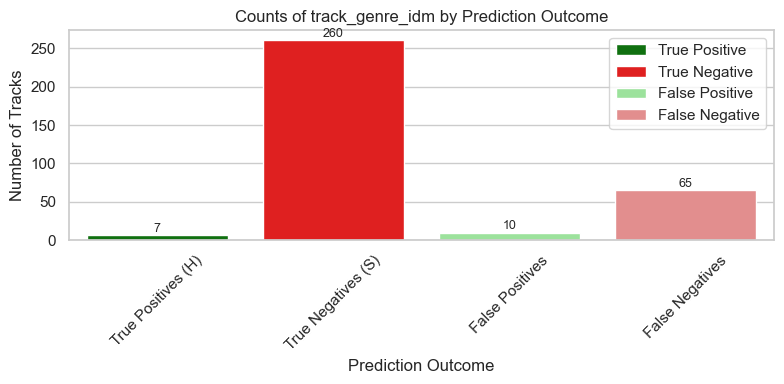

True Positives (H)      7
True Negatives (S)    260
False Positives        10
False Negatives        65
Name: track_genre_idm, dtype: int64


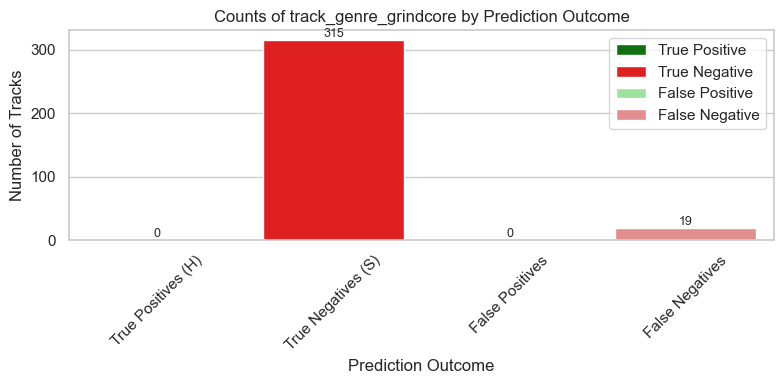

True Positives (H)      0
True Negatives (S)    315
False Positives         0
False Negatives        19
Name: track_genre_grindcore, dtype: int64


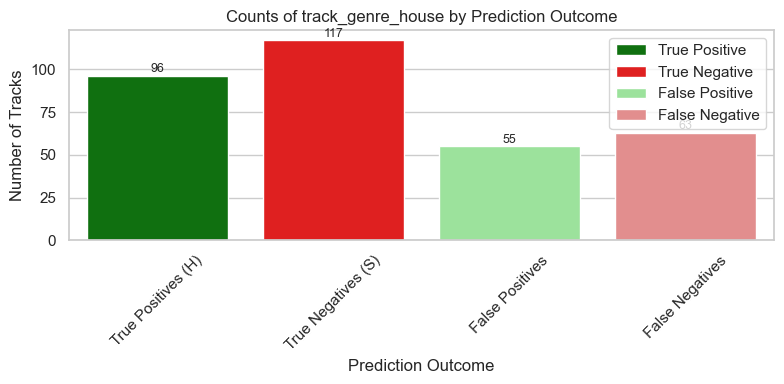

True Positives (H)     96
True Negatives (S)    117
False Positives        55
False Negatives        63
Name: track_genre_house, dtype: int64


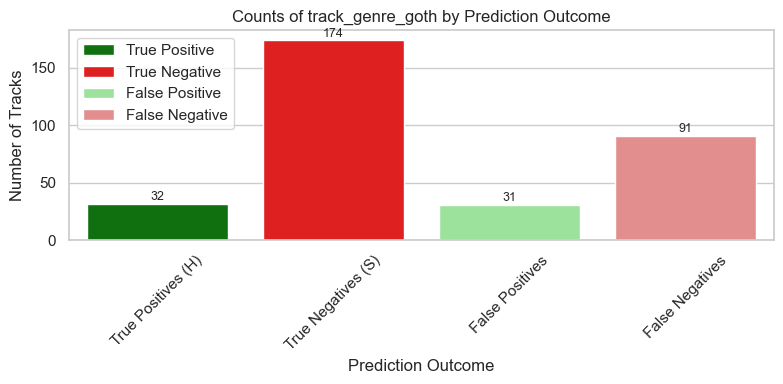

True Positives (H)     32
True Negatives (S)    174
False Positives        31
False Negatives        91
Name: track_genre_goth, dtype: int64


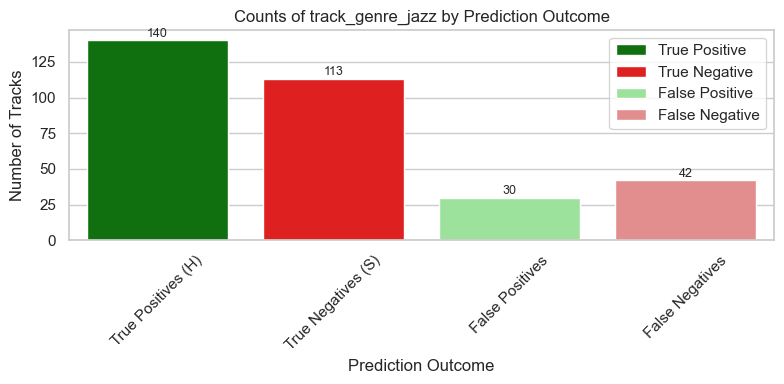

True Positives (H)    140
True Negatives (S)    113
False Positives        30
False Negatives        42
Name: track_genre_jazz, dtype: int64


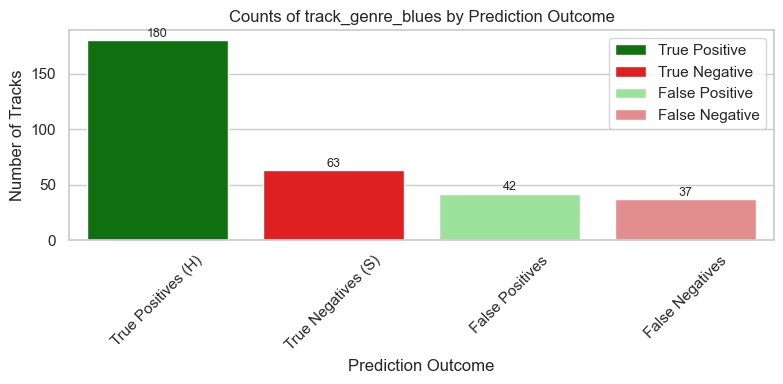

True Positives (H)    180
True Negatives (S)     63
False Positives        42
False Negatives        37
Name: track_genre_blues, dtype: int64


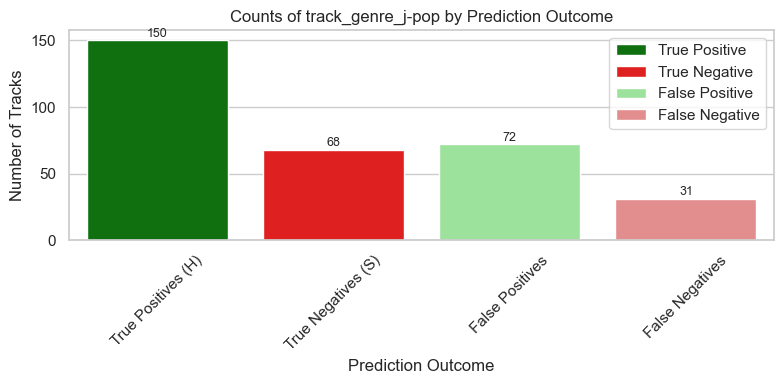

True Positives (H)    150
True Negatives (S)     68
False Positives        72
False Negatives        31
Name: track_genre_j-pop, dtype: int64


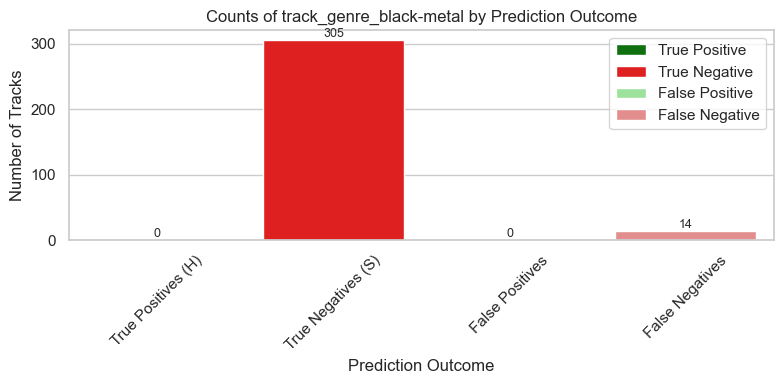

True Positives (H)      0
True Negatives (S)    305
False Positives         0
False Negatives        14
Name: track_genre_black-metal, dtype: int64


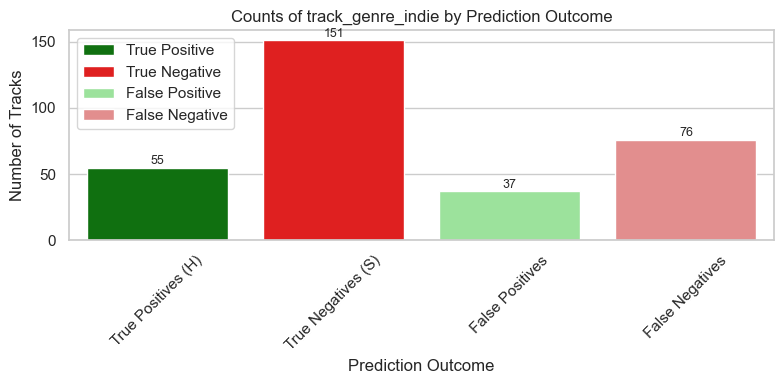

True Positives (H)     55
True Negatives (S)    151
False Positives        37
False Negatives        76
Name: track_genre_indie, dtype: int64


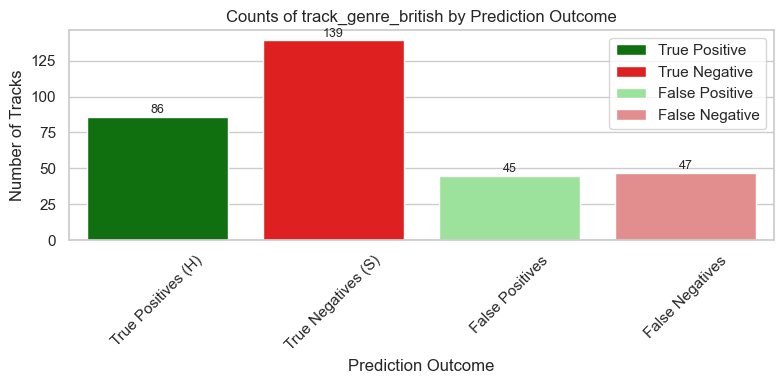

True Positives (H)     86
True Negatives (S)    139
False Positives        45
False Negatives        47
Name: track_genre_british, dtype: int64


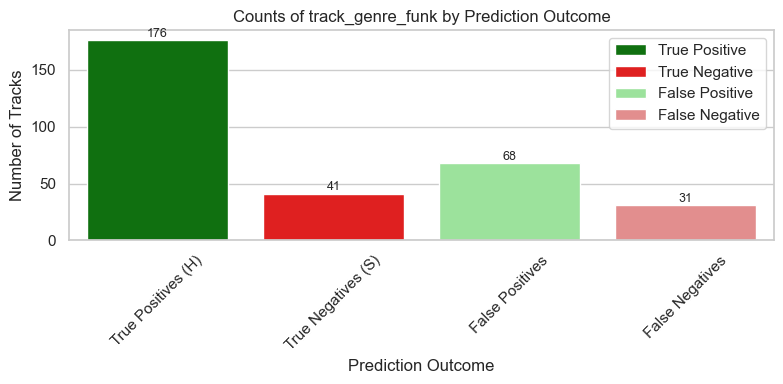

True Positives (H)    176
True Negatives (S)     41
False Positives        68
False Negatives        31
Name: track_genre_funk, dtype: int64


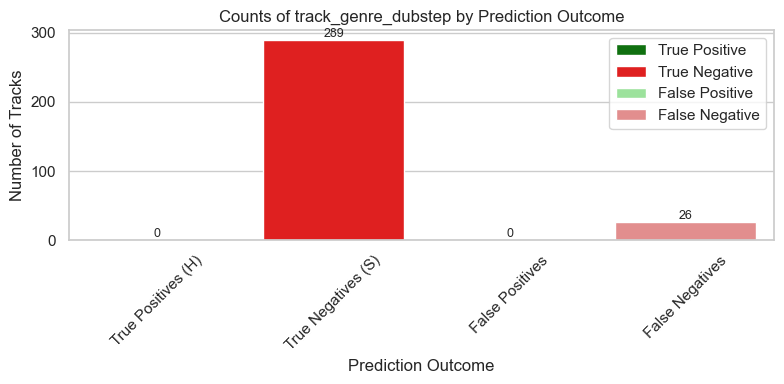

True Positives (H)      0
True Negatives (S)    289
False Positives         0
False Negatives        26
Name: track_genre_dubstep, dtype: int64


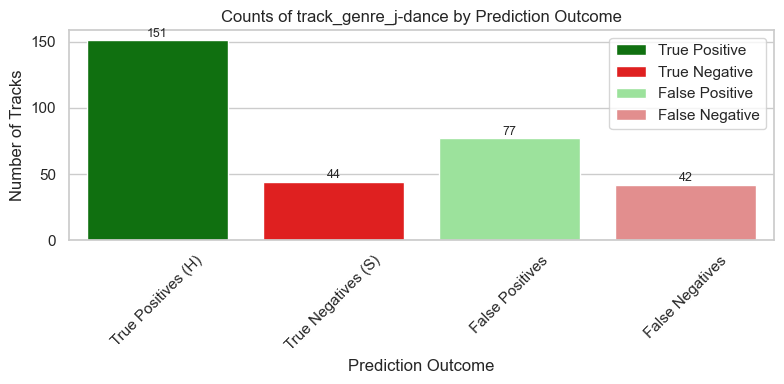

True Positives (H)    151
True Negatives (S)     44
False Positives        77
False Negatives        42
Name: track_genre_j-dance, dtype: int64


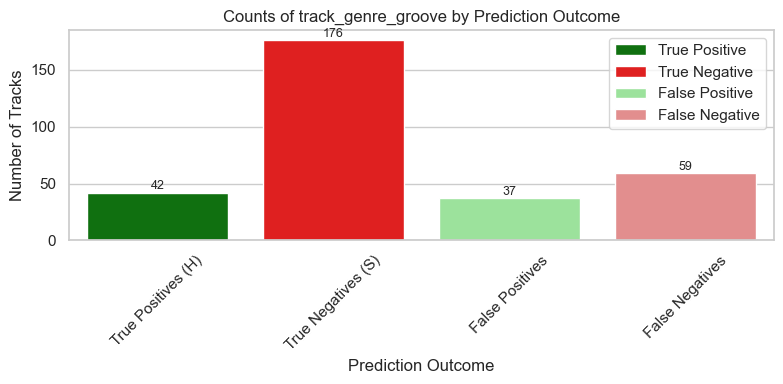

True Positives (H)     42
True Negatives (S)    176
False Positives        37
False Negatives        59
Name: track_genre_groove, dtype: int64


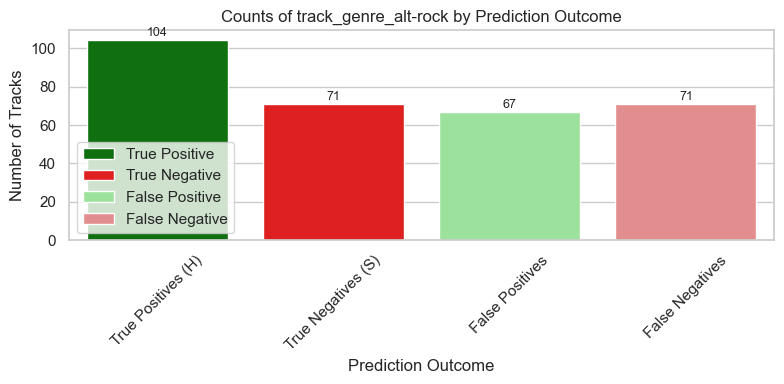

True Positives (H)    104
True Negatives (S)     71
False Positives        67
False Negatives        71
Name: track_genre_alt-rock, dtype: int64


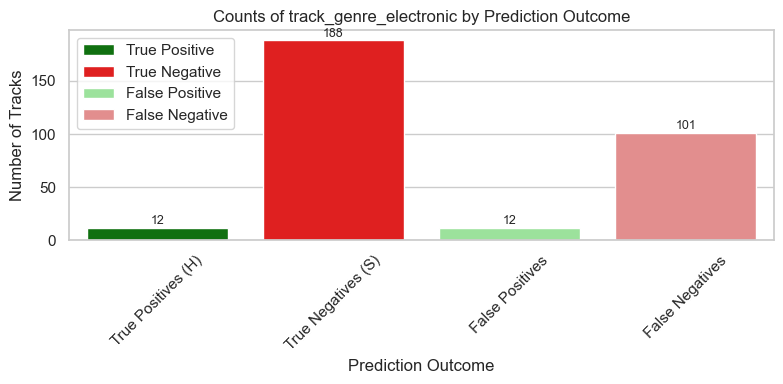

True Positives (H)     12
True Negatives (S)    188
False Positives        12
False Negatives       101
Name: track_genre_electronic, dtype: int64


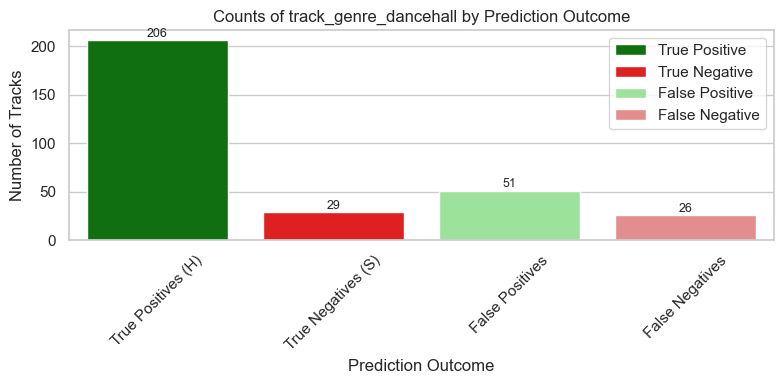

True Positives (H)    206
True Negatives (S)     29
False Positives        51
False Negatives        26
Name: track_genre_dancehall, dtype: int64


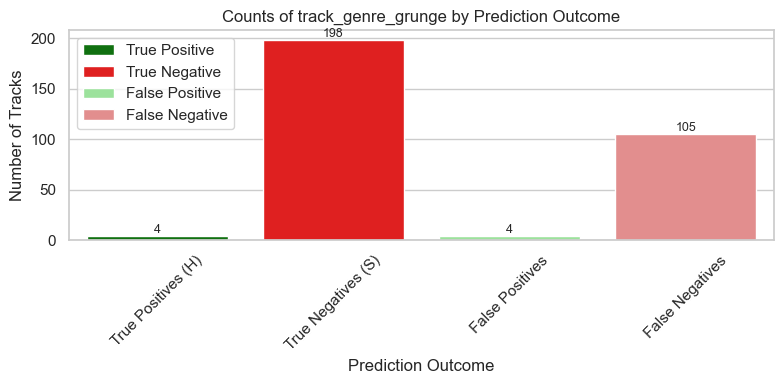

True Positives (H)      4
True Negatives (S)    198
False Positives         4
False Negatives       105
Name: track_genre_grunge, dtype: int64


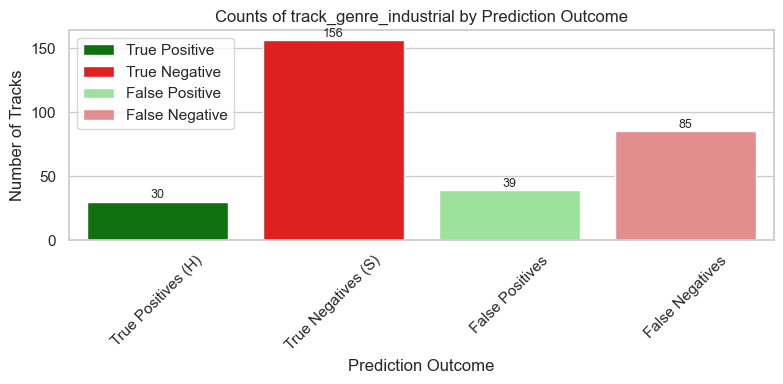

True Positives (H)     30
True Negatives (S)    156
False Positives        39
False Negatives        85
Name: track_genre_industrial, dtype: int64


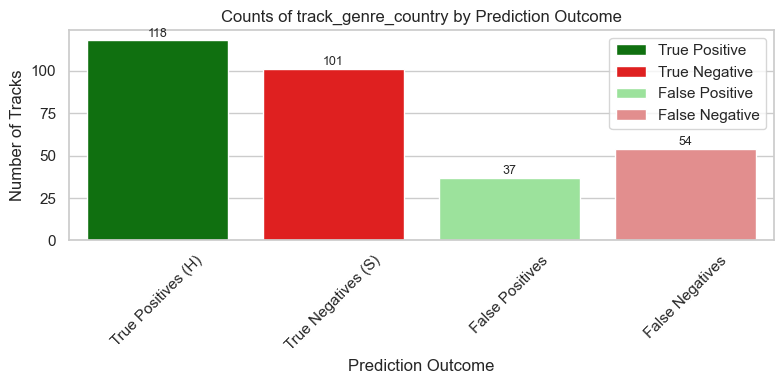

True Positives (H)    118
True Negatives (S)    101
False Positives        37
False Negatives        54
Name: track_genre_country, dtype: int64


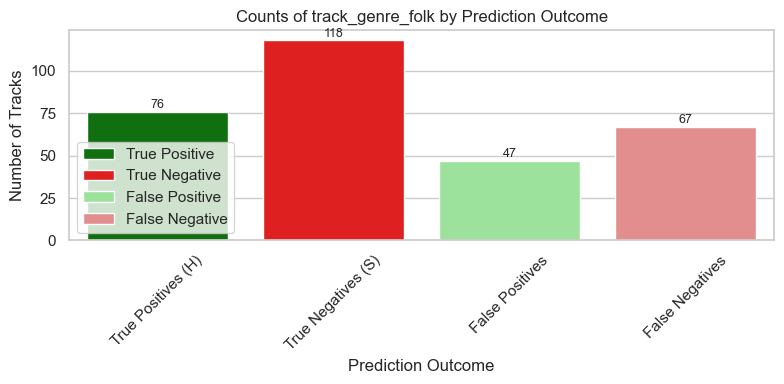

True Positives (H)     76
True Negatives (S)    118
False Positives        47
False Negatives        67
Name: track_genre_folk, dtype: int64


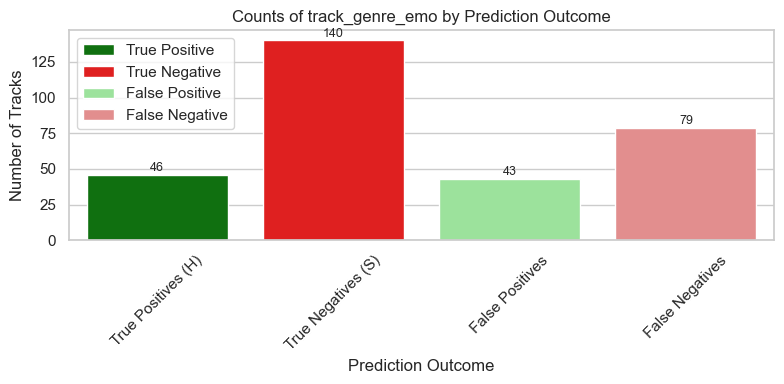

True Positives (H)     46
True Negatives (S)    140
False Positives        43
False Negatives        79
Name: track_genre_emo, dtype: int64


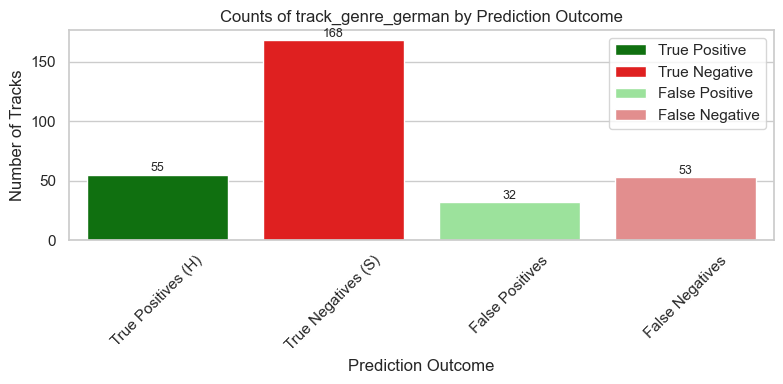

True Positives (H)     55
True Negatives (S)    168
False Positives        32
False Negatives        53
Name: track_genre_german, dtype: int64


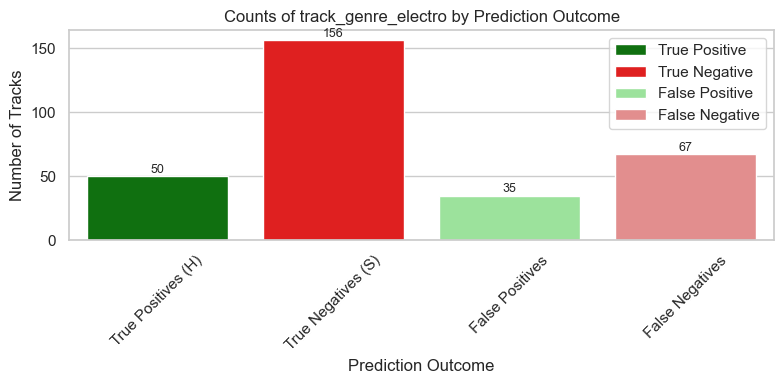

True Positives (H)     50
True Negatives (S)    156
False Positives        35
False Negatives        67
Name: track_genre_electro, dtype: int64


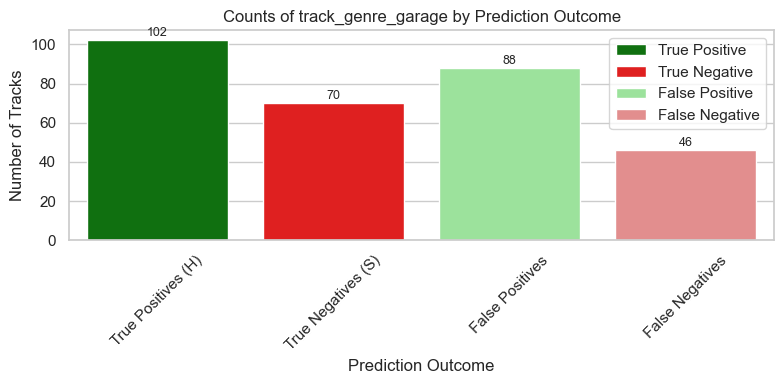

True Positives (H)    102
True Negatives (S)     70
False Positives        88
False Negatives        46
Name: track_genre_garage, dtype: int64


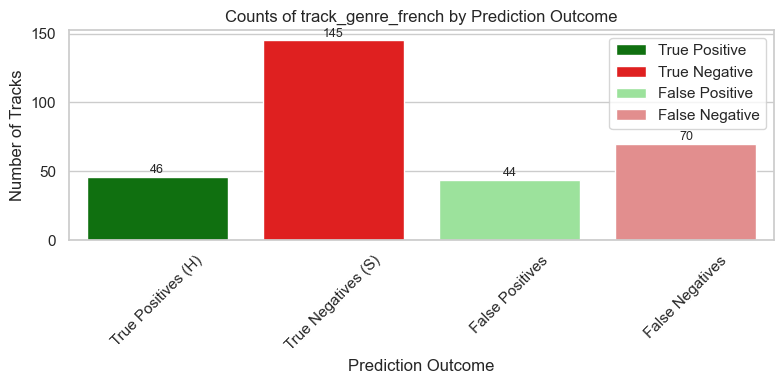

True Positives (H)     46
True Negatives (S)    145
False Positives        44
False Negatives        70
Name: track_genre_french, dtype: int64


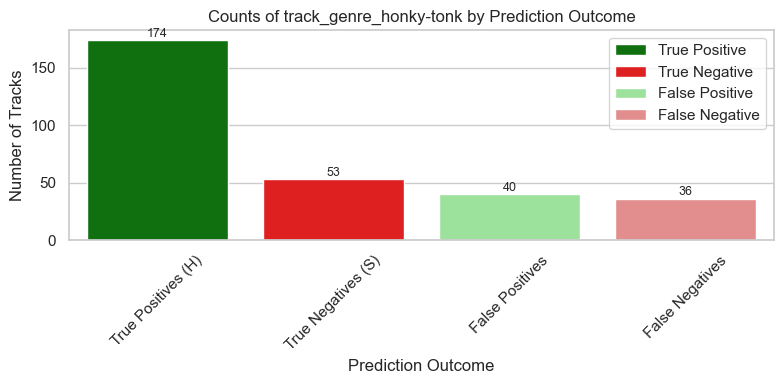

True Positives (H)    174
True Negatives (S)     53
False Positives        40
False Negatives        36
Name: track_genre_honky-tonk, dtype: int64


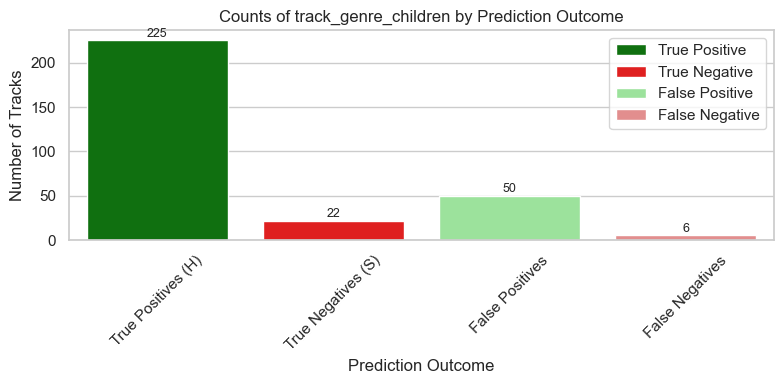

True Positives (H)    225
True Negatives (S)     22
False Positives        50
False Negatives         6
Name: track_genre_children, dtype: int64


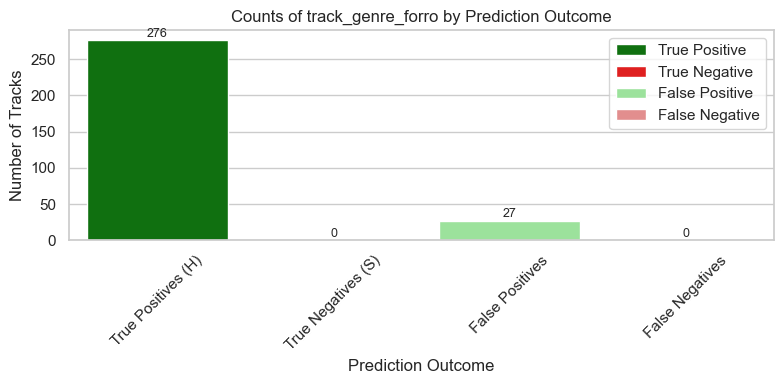

True Positives (H)    276
True Negatives (S)      0
False Positives        27
False Negatives         0
Name: track_genre_forro, dtype: int64


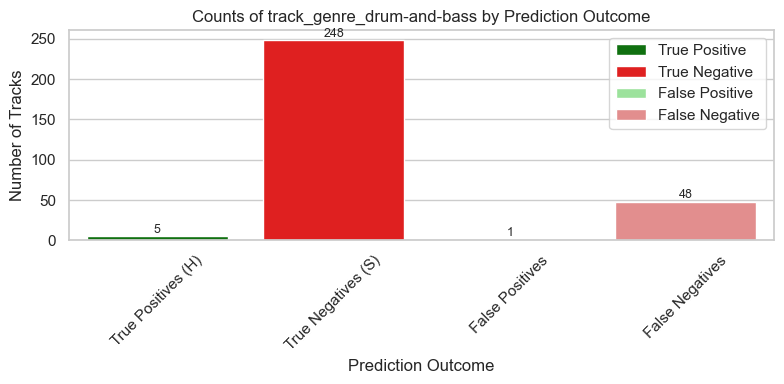

True Positives (H)      5
True Negatives (S)    248
False Positives         1
False Negatives        48
Name: track_genre_drum-and-bass, dtype: int64


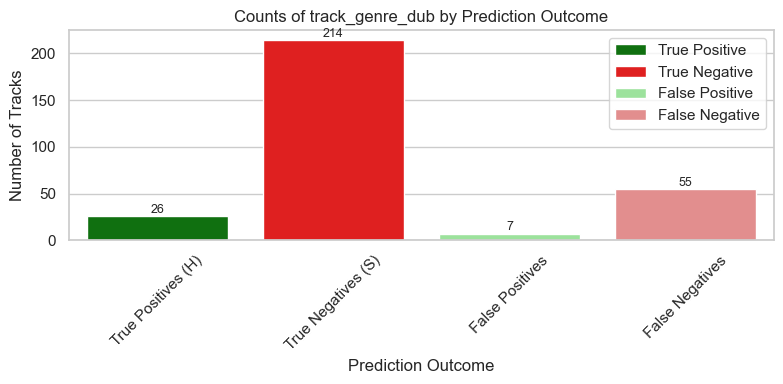

True Positives (H)     26
True Negatives (S)    214
False Positives         7
False Negatives        55
Name: track_genre_dub, dtype: int64


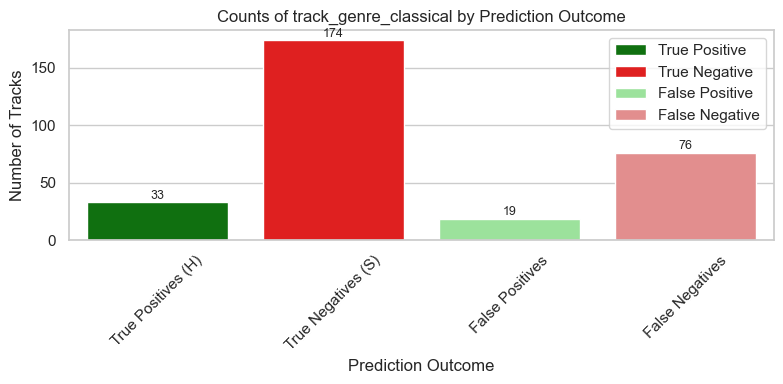

True Positives (H)     33
True Negatives (S)    174
False Positives        19
False Negatives        76
Name: track_genre_classical, dtype: int64


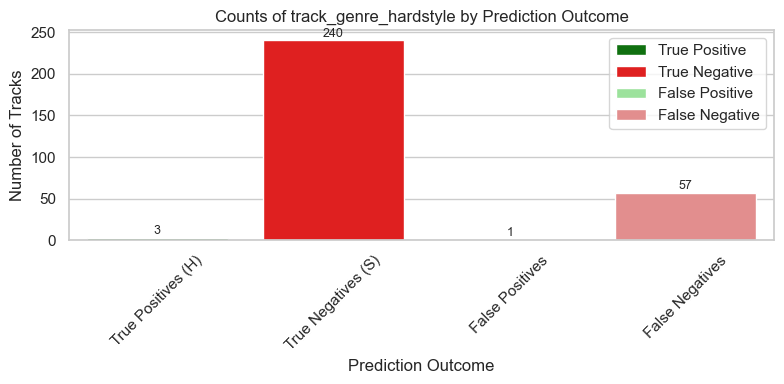

True Positives (H)      3
True Negatives (S)    240
False Positives         1
False Negatives        57
Name: track_genre_hardstyle, dtype: int64


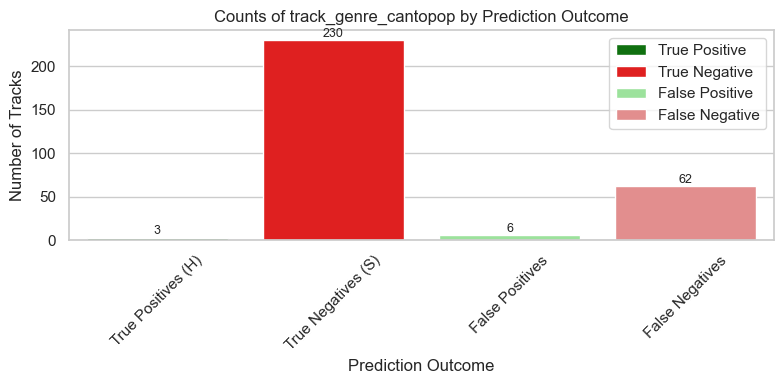

True Positives (H)      3
True Negatives (S)    230
False Positives         6
False Negatives        62
Name: track_genre_cantopop, dtype: int64


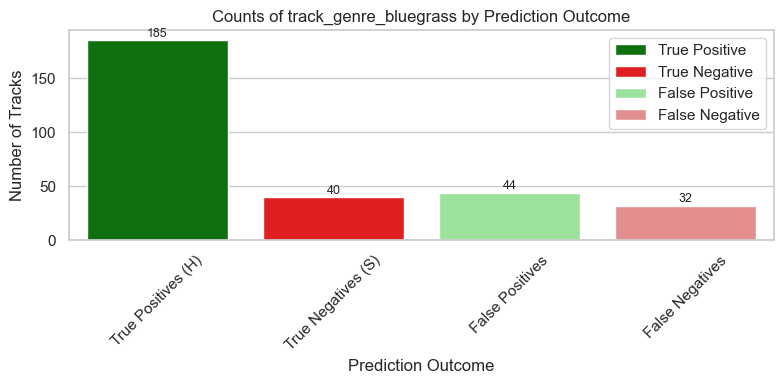

True Positives (H)    185
True Negatives (S)     40
False Positives        44
False Negatives        32
Name: track_genre_bluegrass, dtype: int64


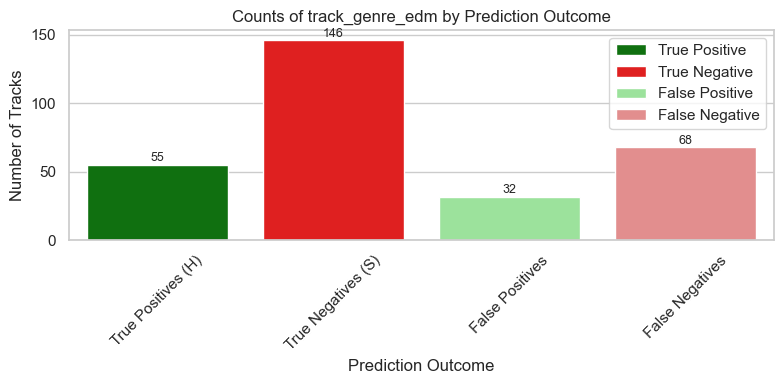

True Positives (H)     55
True Negatives (S)    146
False Positives        32
False Negatives        68
Name: track_genre_edm, dtype: int64


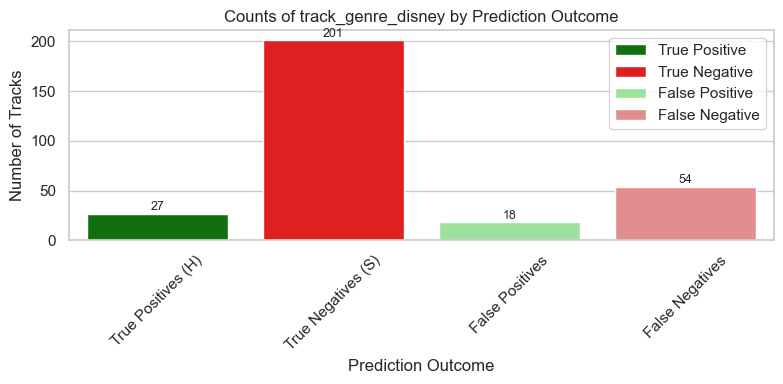

True Positives (H)     27
True Negatives (S)    201
False Positives        18
False Negatives        54
Name: track_genre_disney, dtype: int64


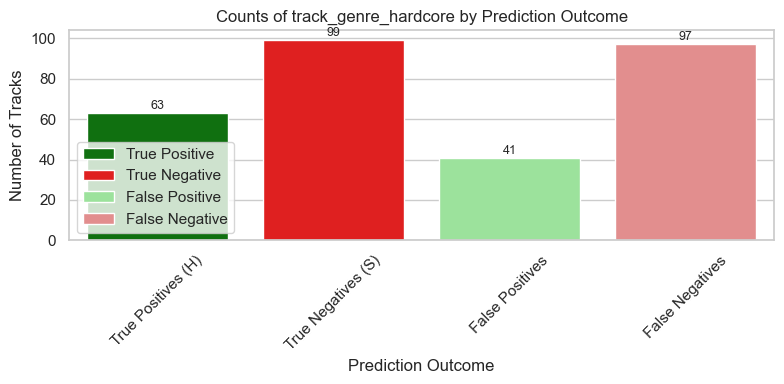

True Positives (H)    63
True Negatives (S)    99
False Positives       41
False Negatives       97
Name: track_genre_hardcore, dtype: int64


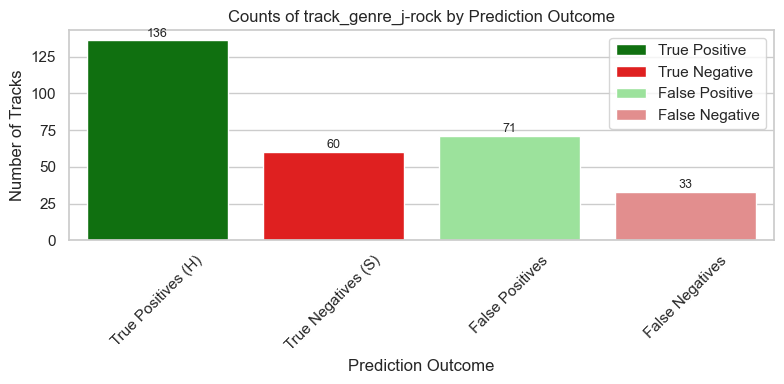

True Positives (H)    136
True Negatives (S)     60
False Positives        71
False Negatives        33
Name: track_genre_j-rock, dtype: int64


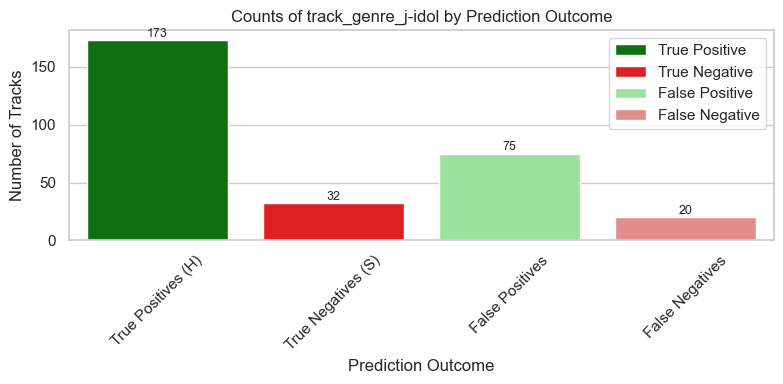

True Positives (H)    173
True Negatives (S)     32
False Positives        75
False Negatives        20
Name: track_genre_j-idol, dtype: int64


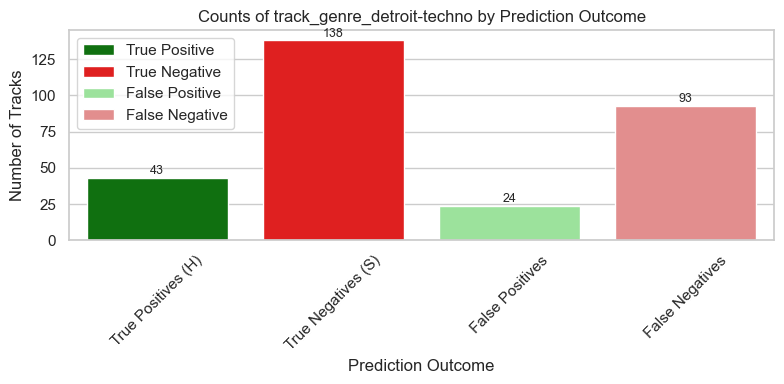

True Positives (H)     43
True Negatives (S)    138
False Positives        24
False Negatives        93
Name: track_genre_detroit-techno, dtype: int64


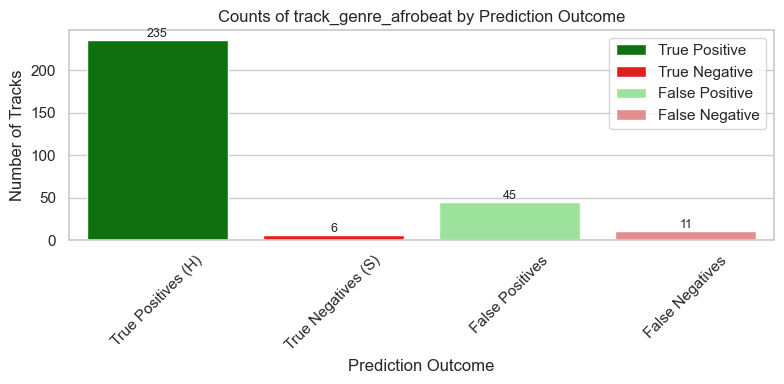

True Positives (H)    235
True Negatives (S)      6
False Positives        45
False Negatives        11
Name: track_genre_afrobeat, dtype: int64


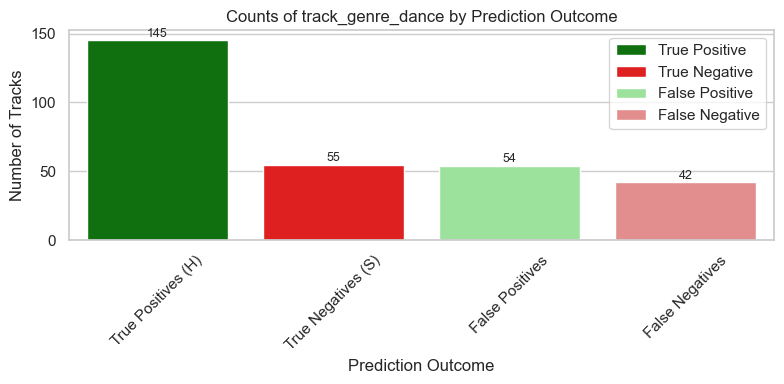

True Positives (H)    145
True Negatives (S)     55
False Positives        54
False Negatives        42
Name: track_genre_dance, dtype: int64


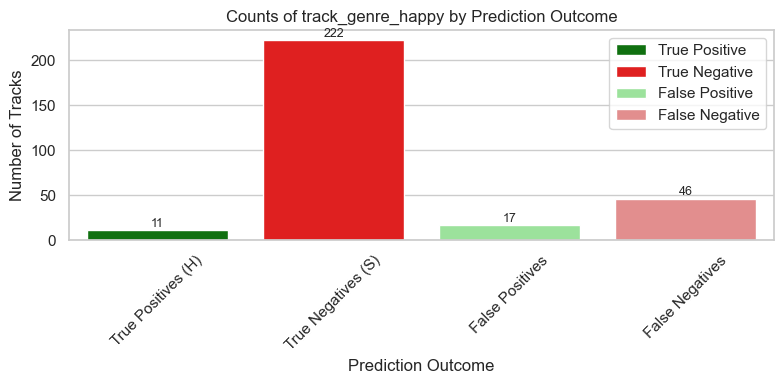

True Positives (H)     11
True Negatives (S)    222
False Positives        17
False Negatives        46
Name: track_genre_happy, dtype: int64


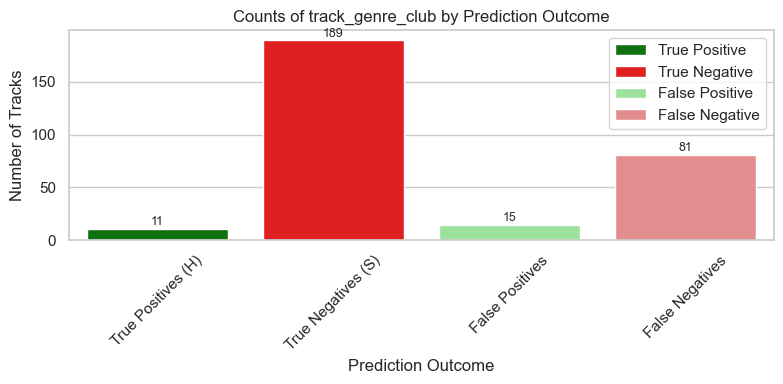

True Positives (H)     11
True Negatives (S)    189
False Positives        15
False Negatives        81
Name: track_genre_club, dtype: int64


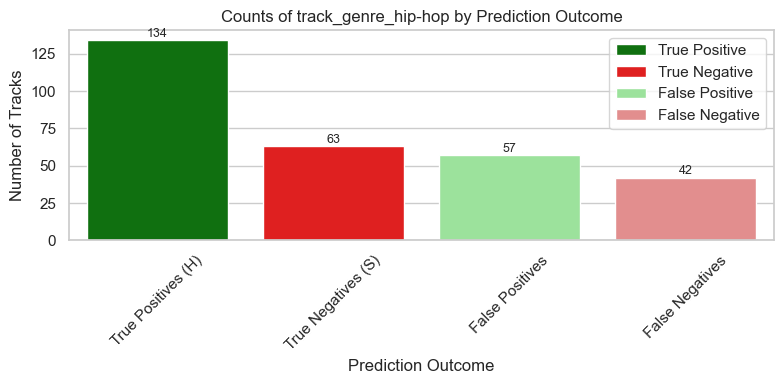

True Positives (H)    134
True Negatives (S)     63
False Positives        57
False Negatives        42
Name: track_genre_hip-hop, dtype: int64


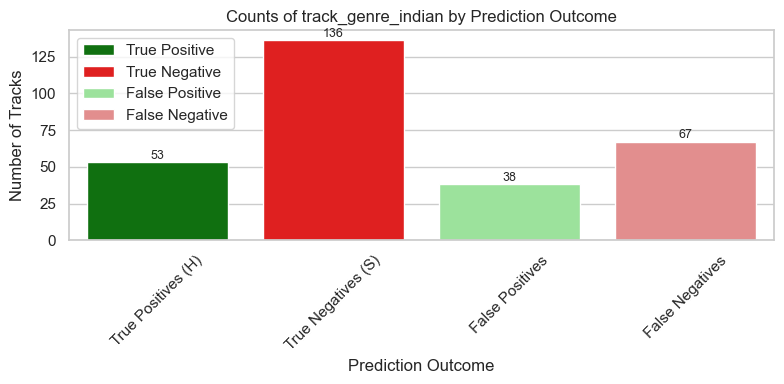

True Positives (H)     53
True Negatives (S)    136
False Positives        38
False Negatives        67
Name: track_genre_indian, dtype: int64


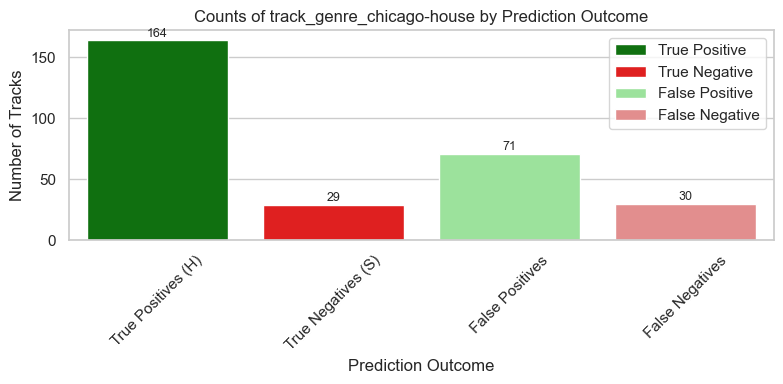

True Positives (H)    164
True Negatives (S)     29
False Positives        71
False Negatives        30
Name: track_genre_chicago-house, dtype: int64


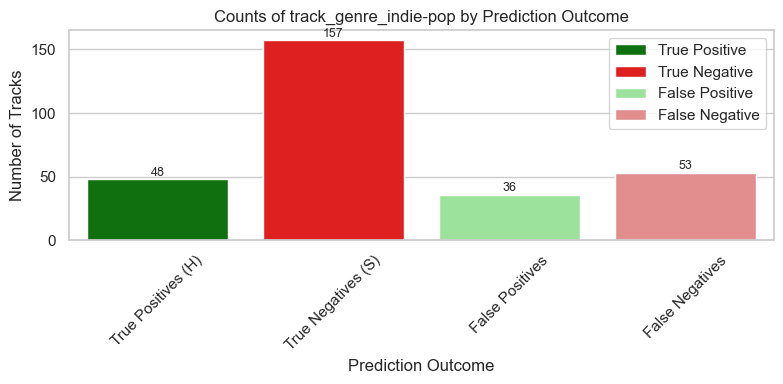

True Positives (H)     48
True Negatives (S)    157
False Positives        36
False Negatives        53
Name: track_genre_indie-pop, dtype: int64


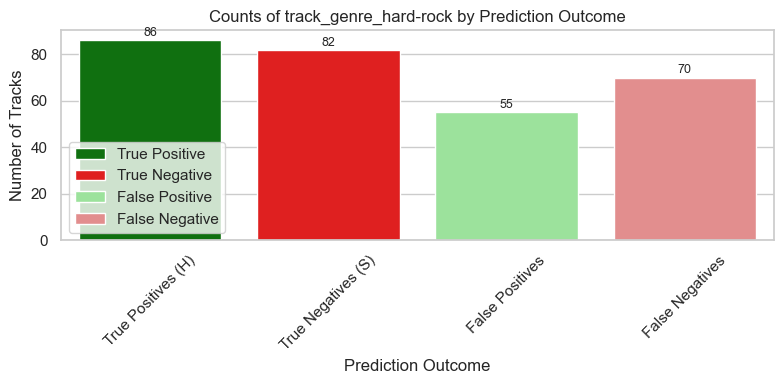

True Positives (H)    86
True Negatives (S)    82
False Positives       55
False Negatives       70
Name: track_genre_hard-rock, dtype: int64


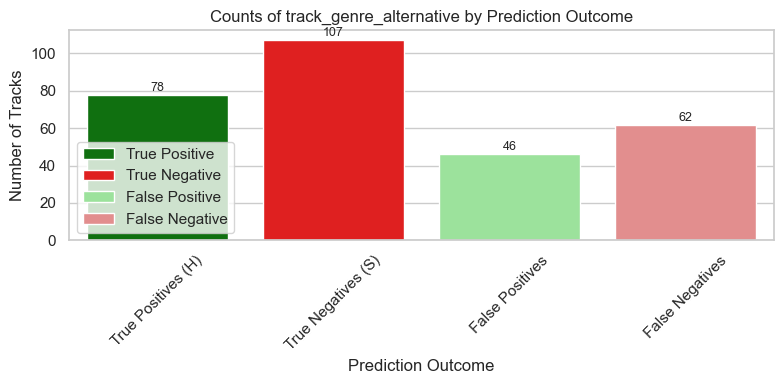

True Positives (H)     78
True Negatives (S)    107
False Positives        46
False Negatives        62
Name: track_genre_alternative, dtype: int64


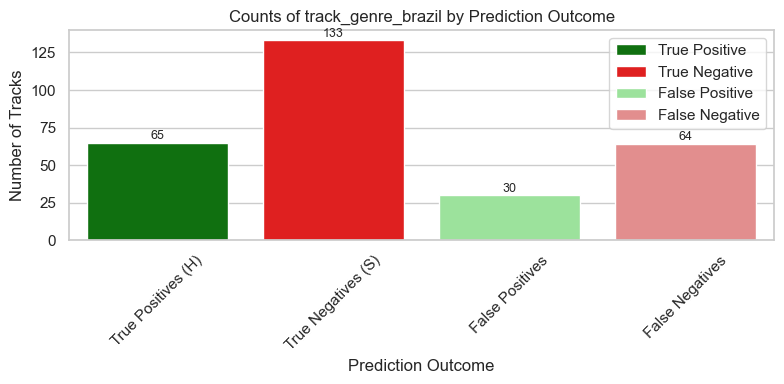

True Positives (H)     65
True Negatives (S)    133
False Positives        30
False Negatives        64
Name: track_genre_brazil, dtype: int64


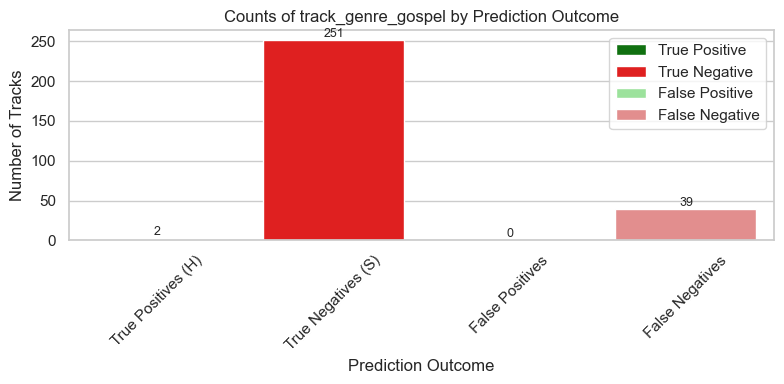

True Positives (H)      2
True Negatives (S)    251
False Positives         0
False Negatives        39
Name: track_genre_gospel, dtype: int64


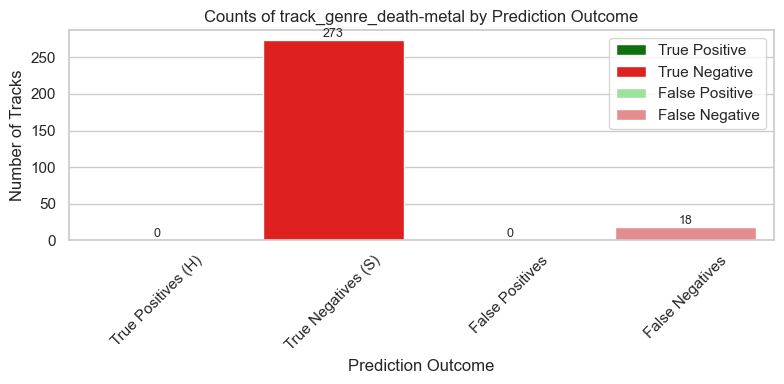

True Positives (H)      0
True Negatives (S)    273
False Positives         0
False Negatives        18
Name: track_genre_death-metal, dtype: int64


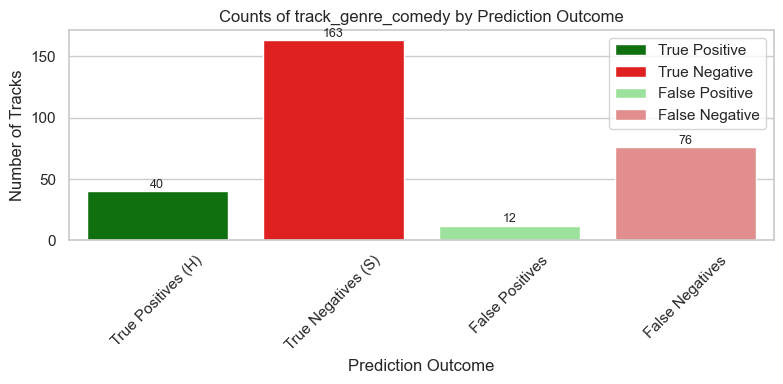

True Positives (H)     40
True Negatives (S)    163
False Positives        12
False Negatives        76
Name: track_genre_comedy, dtype: int64


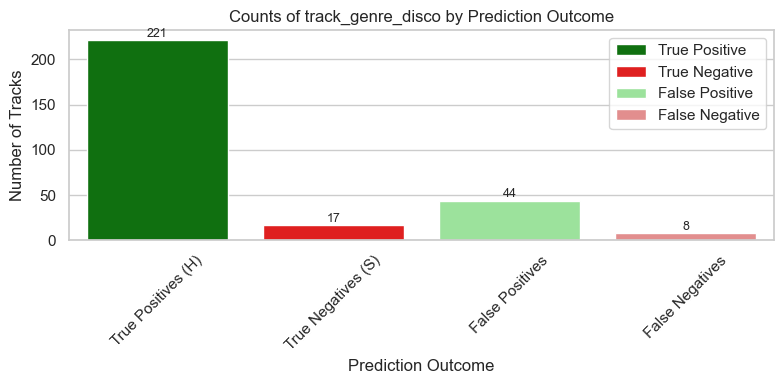

True Positives (H)    221
True Negatives (S)     17
False Positives        44
False Negatives         8
Name: track_genre_disco, dtype: int64


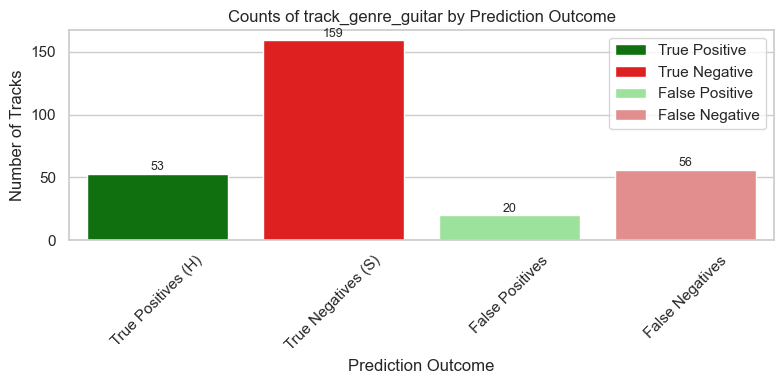

True Positives (H)     53
True Negatives (S)    159
False Positives        20
False Negatives        56
Name: track_genre_guitar, dtype: int64


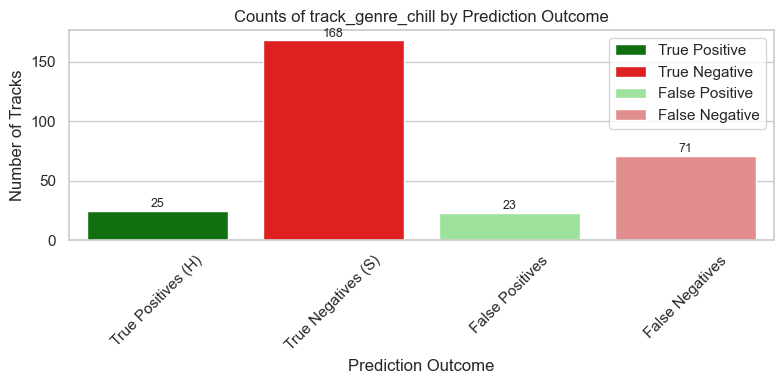

True Positives (H)     25
True Negatives (S)    168
False Positives        23
False Negatives        71
Name: track_genre_chill, dtype: int64


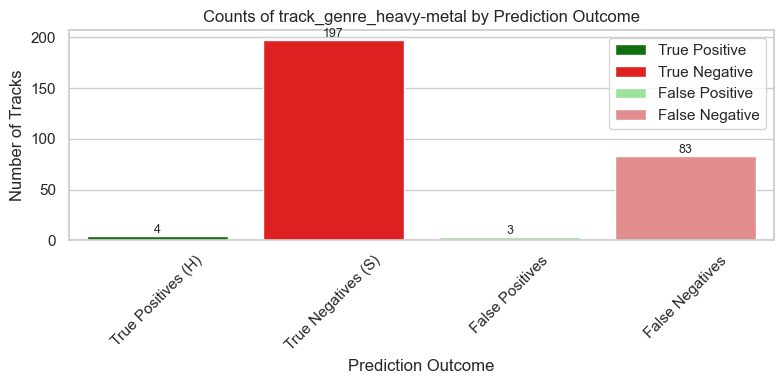

True Positives (H)      4
True Negatives (S)    197
False Positives         3
False Negatives        83
Name: track_genre_heavy-metal, dtype: int64


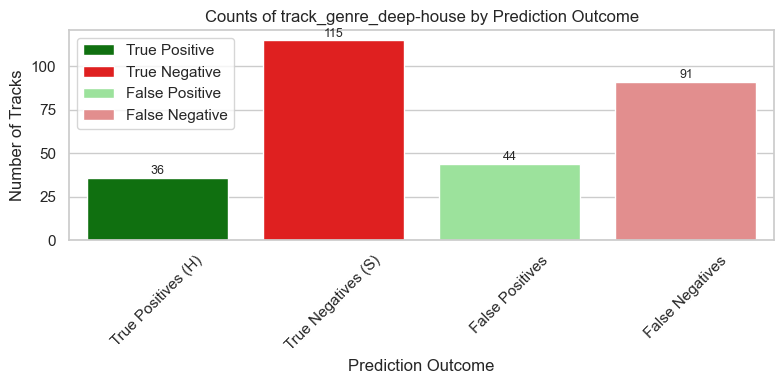

True Positives (H)     36
True Negatives (S)    115
False Positives        44
False Negatives        91
Name: track_genre_deep-house, dtype: int64


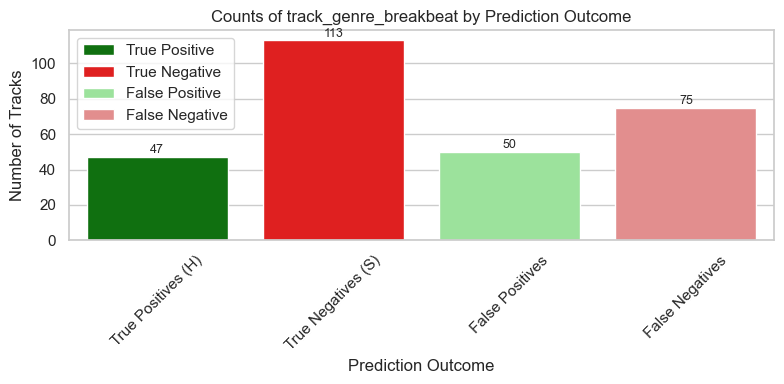

True Positives (H)     47
True Negatives (S)    113
False Positives        50
False Negatives        75
Name: track_genre_breakbeat, dtype: int64


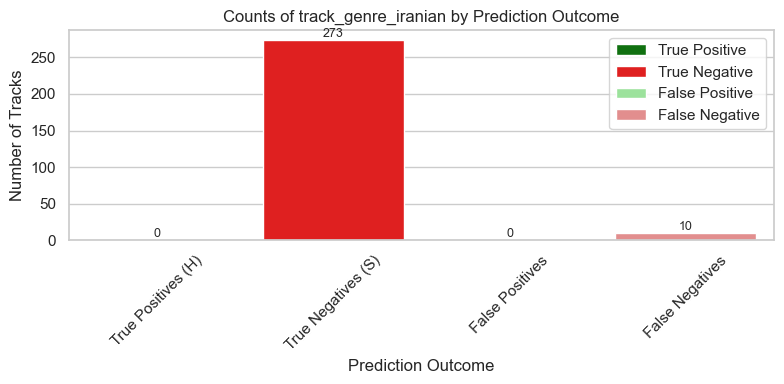

True Positives (H)      0
True Negatives (S)    273
False Positives         0
False Negatives        10
Name: track_genre_iranian, dtype: int64


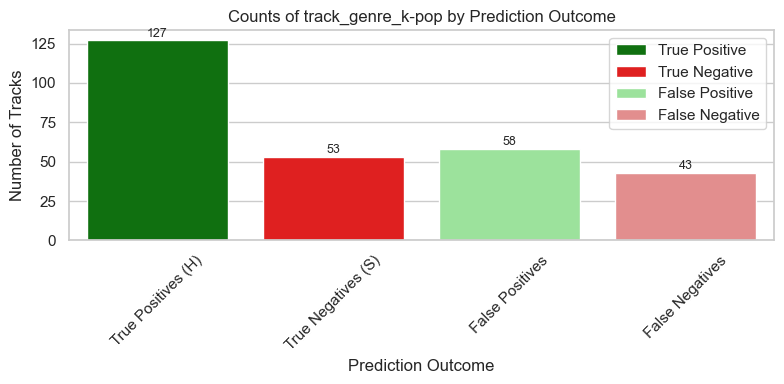

True Positives (H)    127
True Negatives (S)     53
False Positives        58
False Negatives        43
Name: track_genre_k-pop, dtype: int64


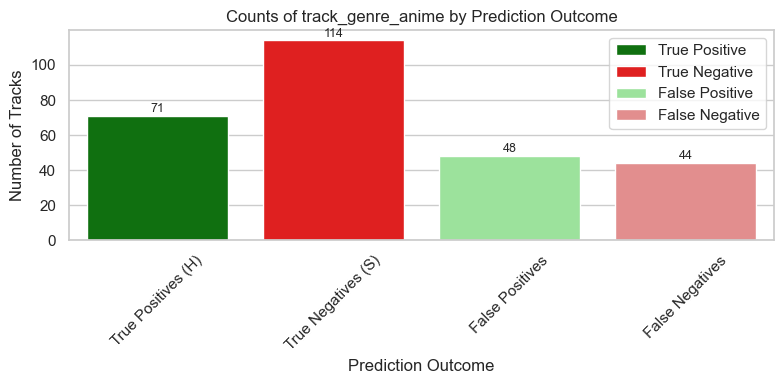

True Positives (H)     71
True Negatives (S)    114
False Positives        48
False Negatives        44
Name: track_genre_anime, dtype: int64


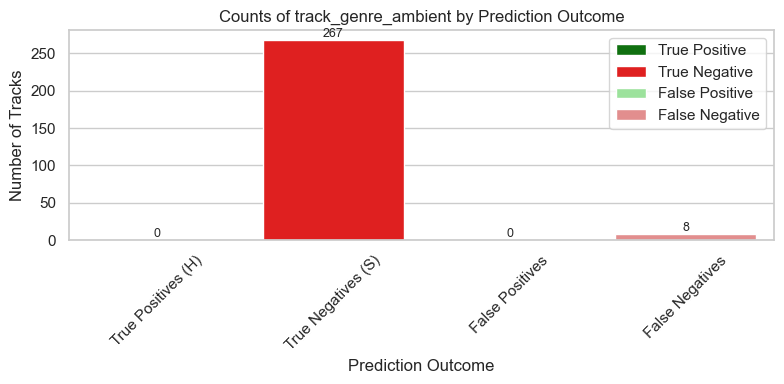

True Positives (H)      0
True Negatives (S)    267
False Positives         0
False Negatives         8
Name: track_genre_ambient, dtype: int64


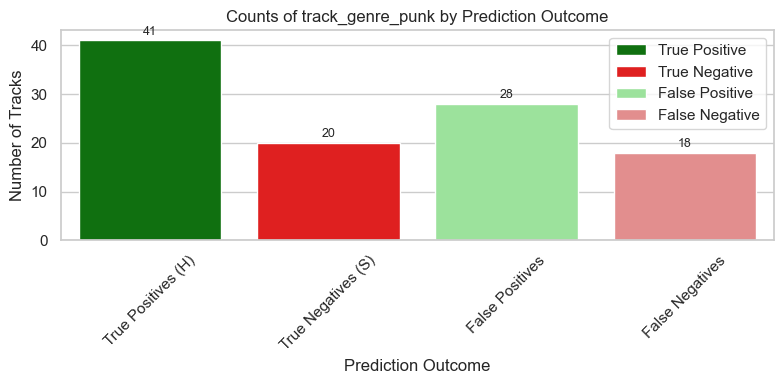

True Positives (H)    41
True Negatives (S)    20
False Positives       28
False Negatives       18
Name: track_genre_punk, dtype: int64


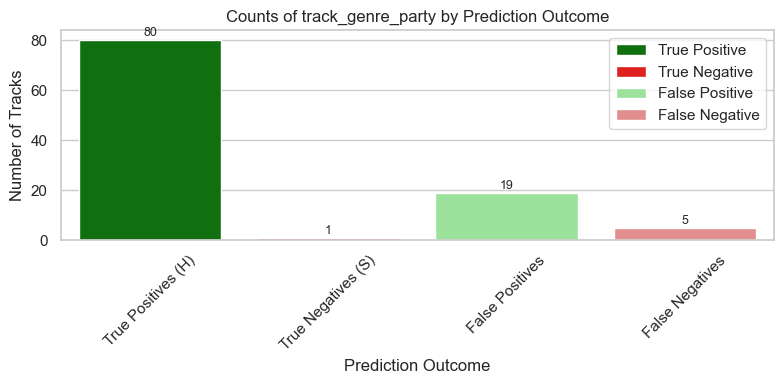

True Positives (H)    80
True Negatives (S)     1
False Positives       19
False Negatives        5
Name: track_genre_party, dtype: int64


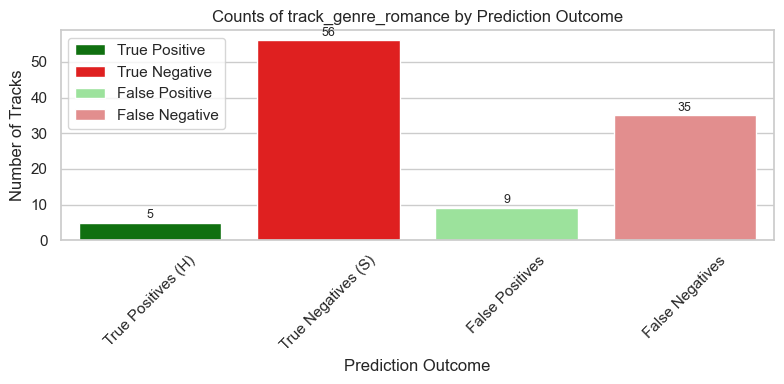

True Positives (H)     5
True Negatives (S)    56
False Positives        9
False Negatives       35
Name: track_genre_romance, dtype: int64


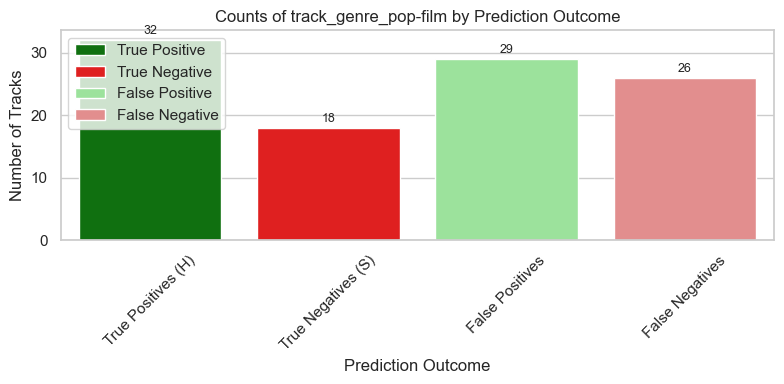

True Positives (H)    32
True Negatives (S)    18
False Positives       29
False Negatives       26
Name: track_genre_pop-film, dtype: int64


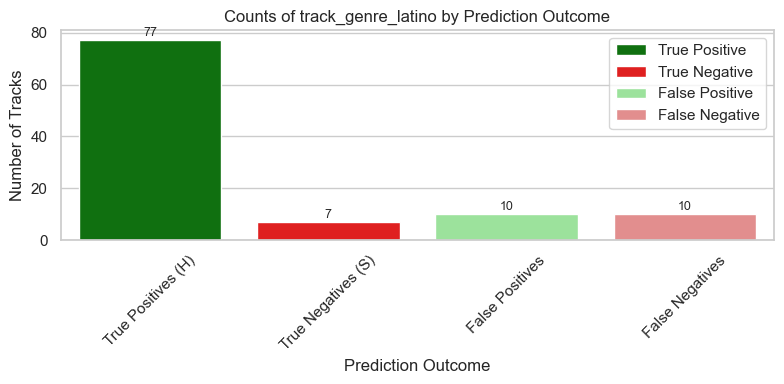

True Positives (H)    77
True Negatives (S)     7
False Positives       10
False Negatives       10
Name: track_genre_latino, dtype: int64


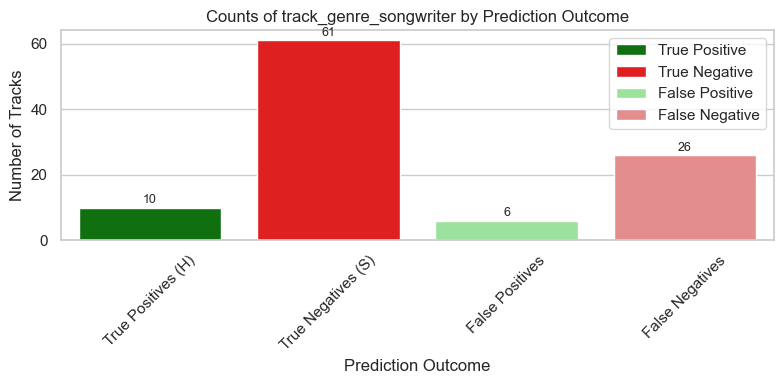

True Positives (H)    10
True Negatives (S)    61
False Positives        6
False Negatives       26
Name: track_genre_songwriter, dtype: int64


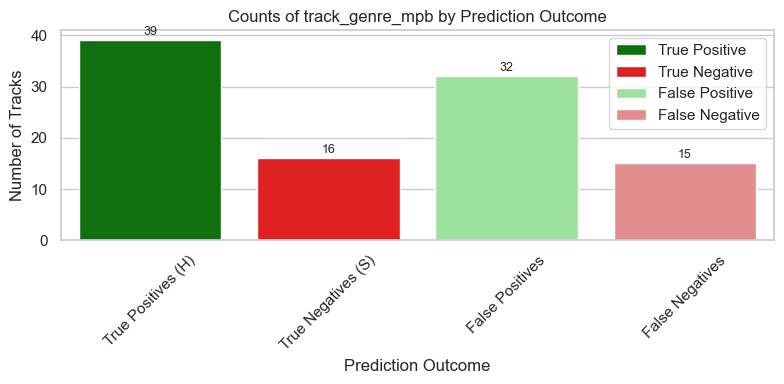

True Positives (H)    39
True Negatives (S)    16
False Positives       32
False Negatives       15
Name: track_genre_mpb, dtype: int64


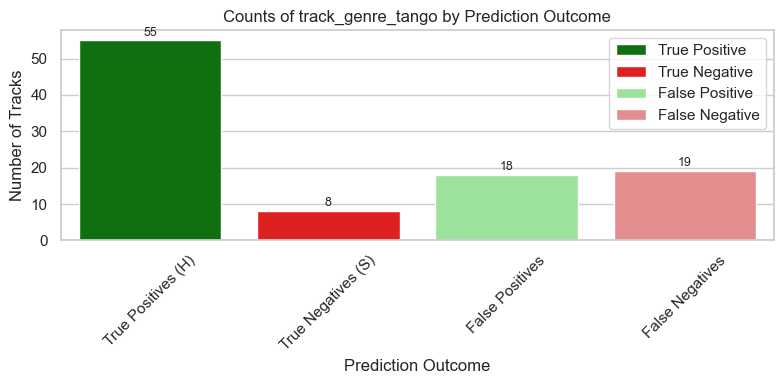

True Positives (H)    55
True Negatives (S)     8
False Positives       18
False Negatives       19
Name: track_genre_tango, dtype: int64


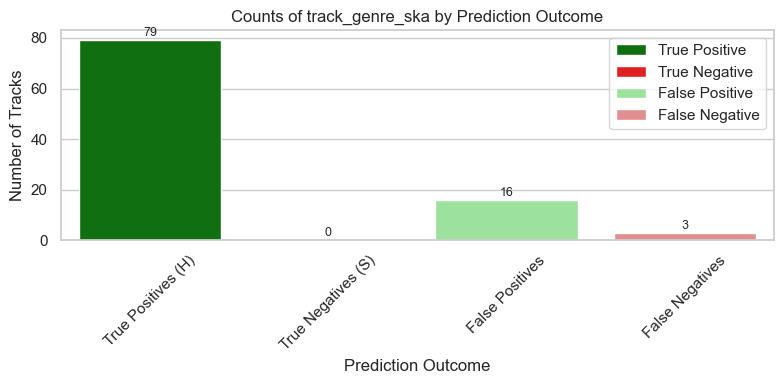

True Positives (H)    79
True Negatives (S)     0
False Positives       16
False Negatives        3
Name: track_genre_ska, dtype: int64


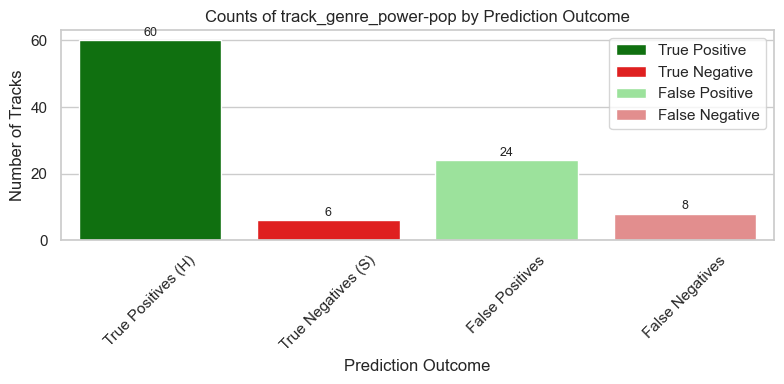

True Positives (H)    60
True Negatives (S)     6
False Positives       24
False Negatives        8
Name: track_genre_power-pop, dtype: int64


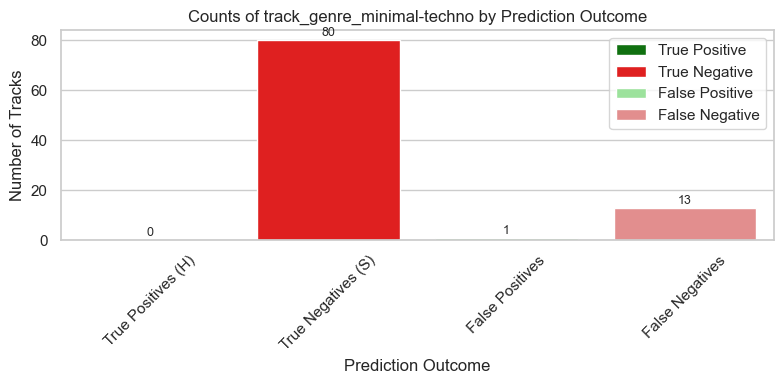

True Positives (H)     0
True Negatives (S)    80
False Positives        1
False Negatives       13
Name: track_genre_minimal-techno, dtype: int64


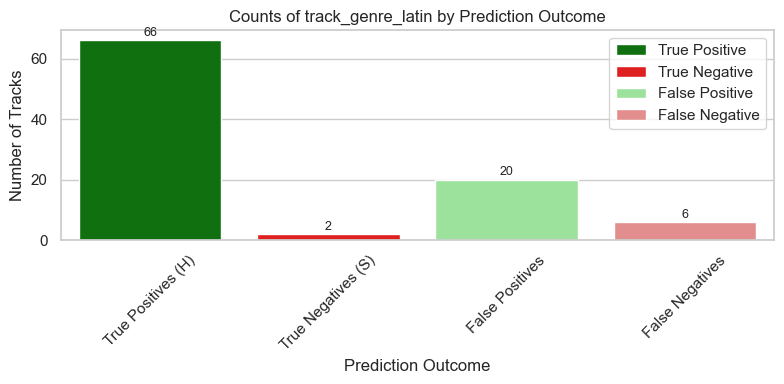

True Positives (H)    66
True Negatives (S)     2
False Positives       20
False Negatives        6
Name: track_genre_latin, dtype: int64


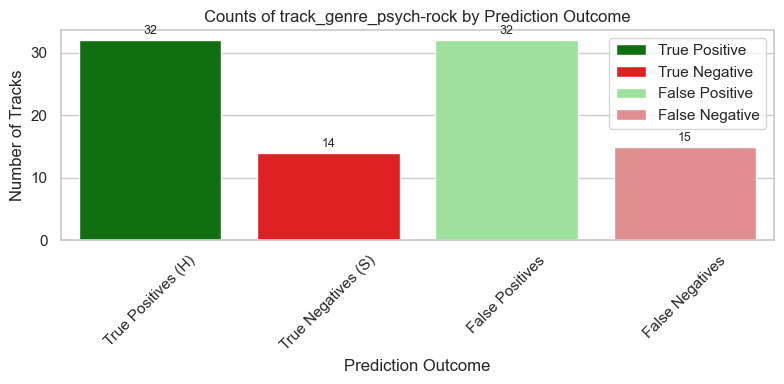

True Positives (H)    32
True Negatives (S)    14
False Positives       32
False Negatives       15
Name: track_genre_psych-rock, dtype: int64


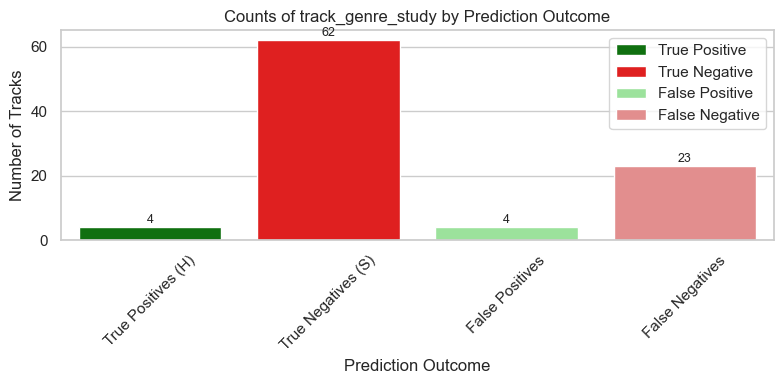

True Positives (H)     4
True Negatives (S)    62
False Positives        4
False Negatives       23
Name: track_genre_study, dtype: int64


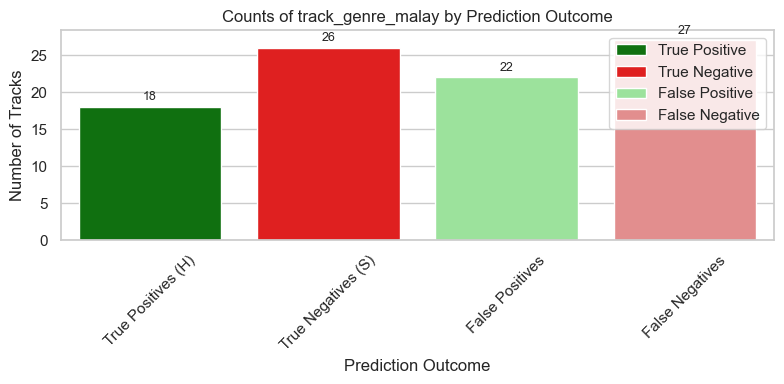

True Positives (H)    18
True Negatives (S)    26
False Positives       22
False Negatives       27
Name: track_genre_malay, dtype: int64


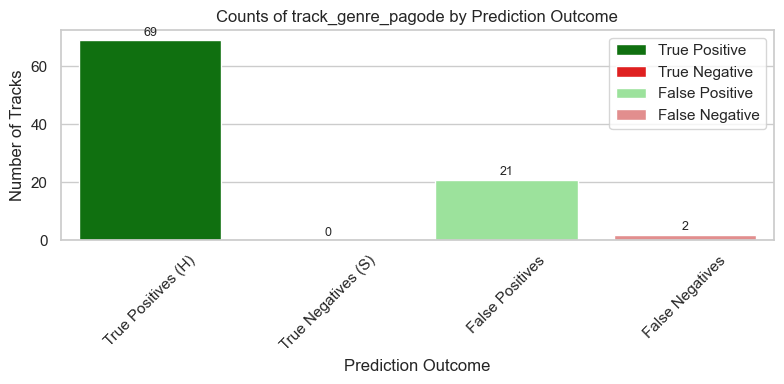

True Positives (H)    69
True Negatives (S)     0
False Positives       21
False Negatives        2
Name: track_genre_pagode, dtype: int64


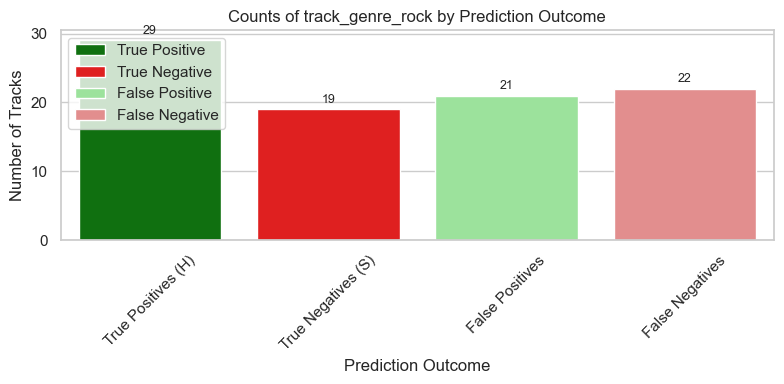

True Positives (H)    29
True Negatives (S)    19
False Positives       21
False Negatives       22
Name: track_genre_rock, dtype: int64


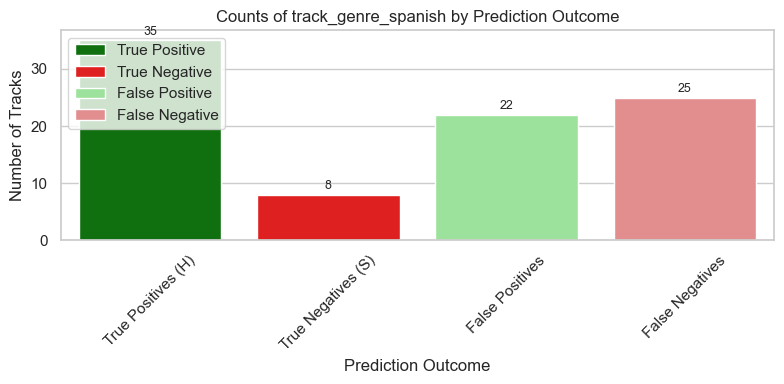

True Positives (H)    35
True Negatives (S)     8
False Positives       22
False Negatives       25
Name: track_genre_spanish, dtype: int64


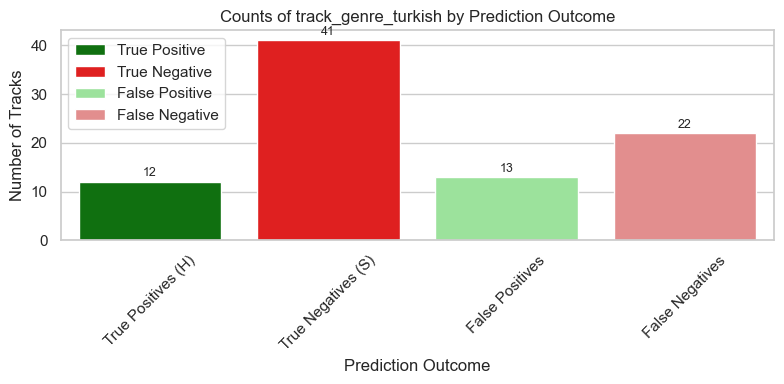

True Positives (H)    12
True Negatives (S)    41
False Positives       13
False Negatives       22
Name: track_genre_turkish, dtype: int64


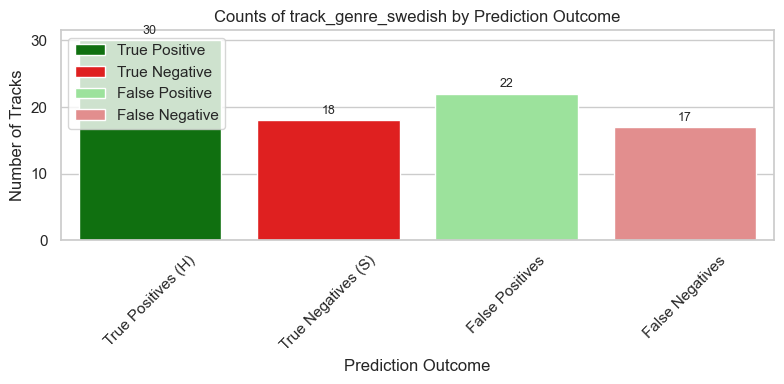

True Positives (H)    30
True Negatives (S)    18
False Positives       22
False Negatives       17
Name: track_genre_swedish, dtype: int64


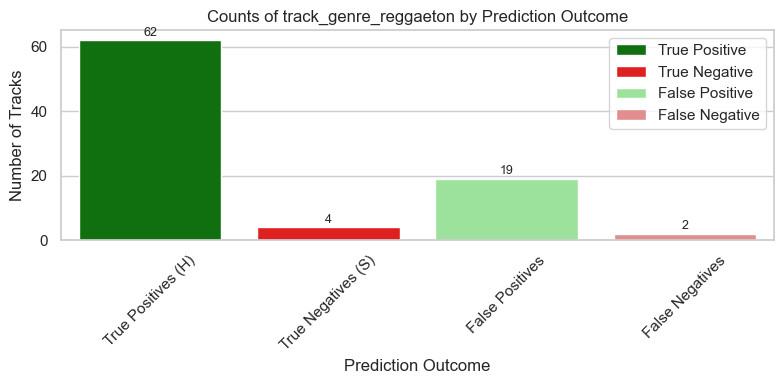

True Positives (H)    62
True Negatives (S)     4
False Positives       19
False Negatives        2
Name: track_genre_reggaeton, dtype: int64


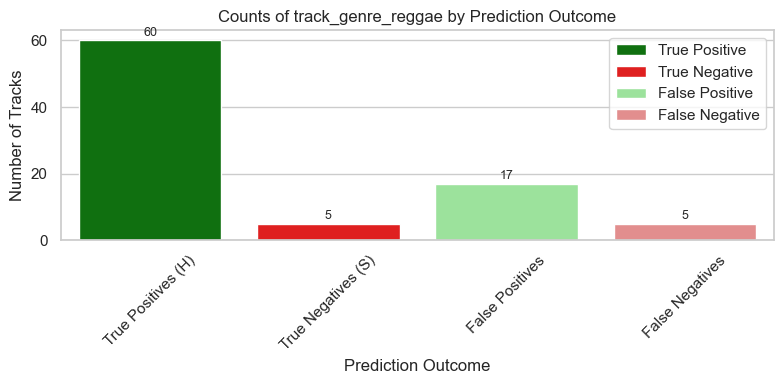

True Positives (H)    60
True Negatives (S)     5
False Positives       17
False Negatives        5
Name: track_genre_reggae, dtype: int64


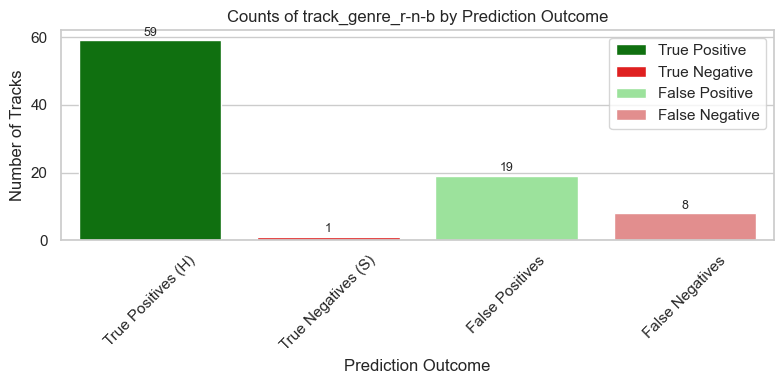

True Positives (H)    59
True Negatives (S)     1
False Positives       19
False Negatives        8
Name: track_genre_r-n-b, dtype: int64


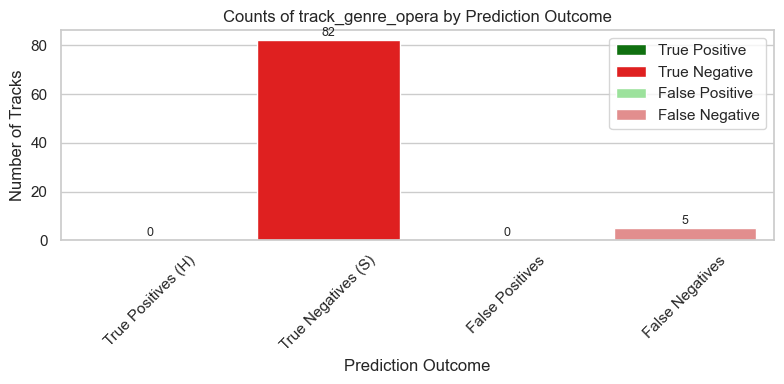

True Positives (H)     0
True Negatives (S)    82
False Positives        0
False Negatives        5
Name: track_genre_opera, dtype: int64


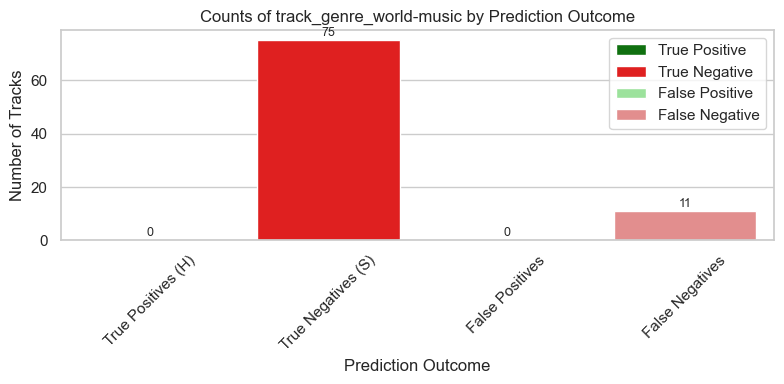

True Positives (H)     0
True Negatives (S)    75
False Positives        0
False Negatives       11
Name: track_genre_world-music, dtype: int64


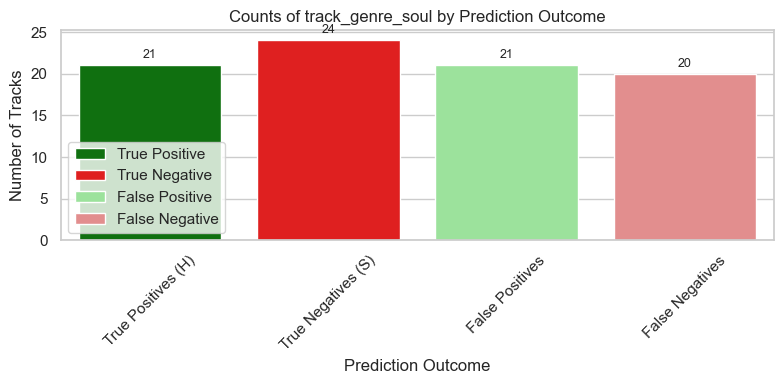

True Positives (H)    21
True Negatives (S)    24
False Positives       21
False Negatives       20
Name: track_genre_soul, dtype: int64


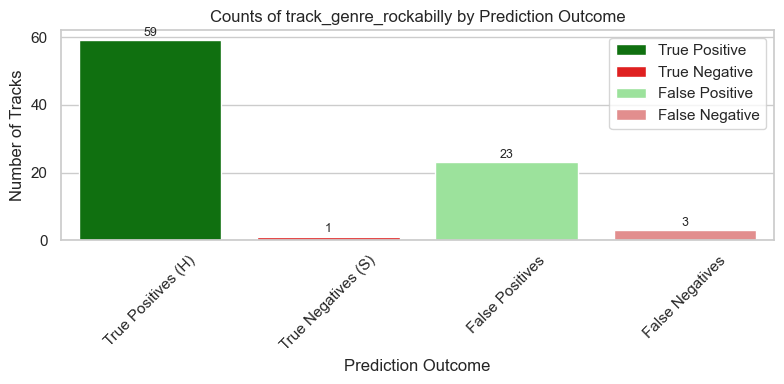

True Positives (H)    59
True Negatives (S)     1
False Positives       23
False Negatives        3
Name: track_genre_rockabilly, dtype: int64


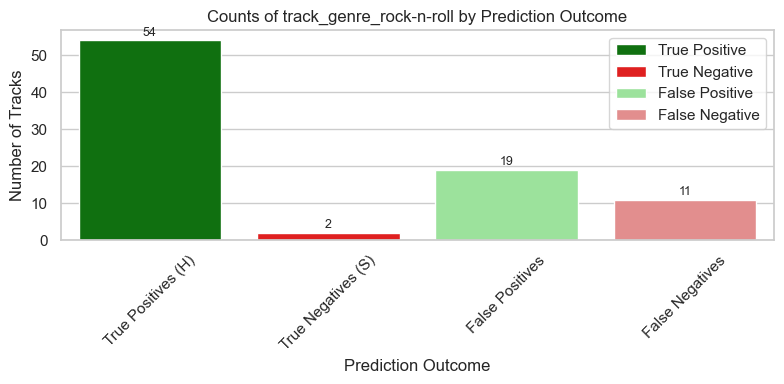

True Positives (H)    54
True Negatives (S)     2
False Positives       19
False Negatives       11
Name: track_genre_rock-n-roll, dtype: int64


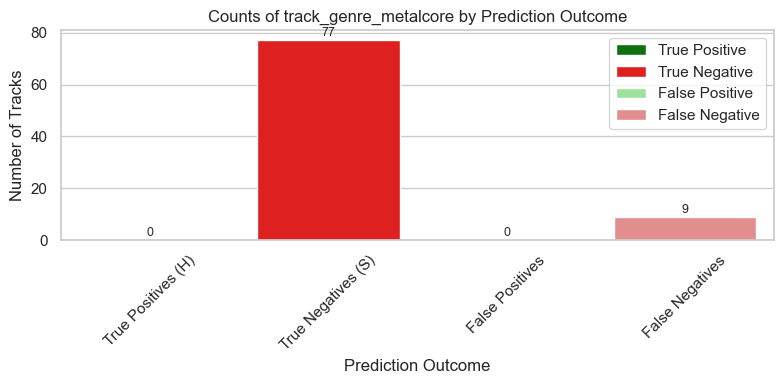

True Positives (H)     0
True Negatives (S)    77
False Positives        0
False Negatives        9
Name: track_genre_metalcore, dtype: int64


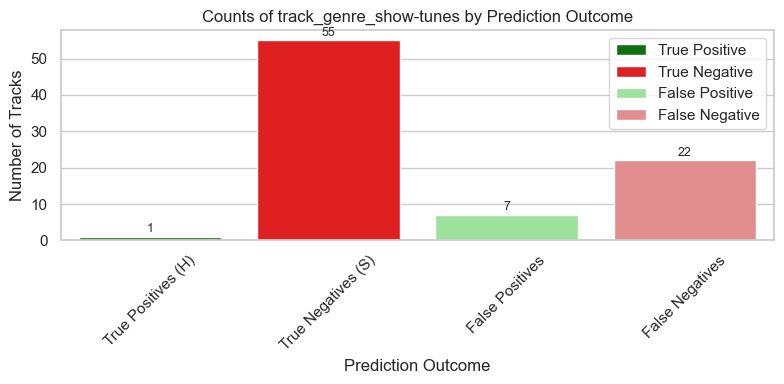

True Positives (H)     1
True Negatives (S)    55
False Positives        7
False Negatives       22
Name: track_genre_show-tunes, dtype: int64


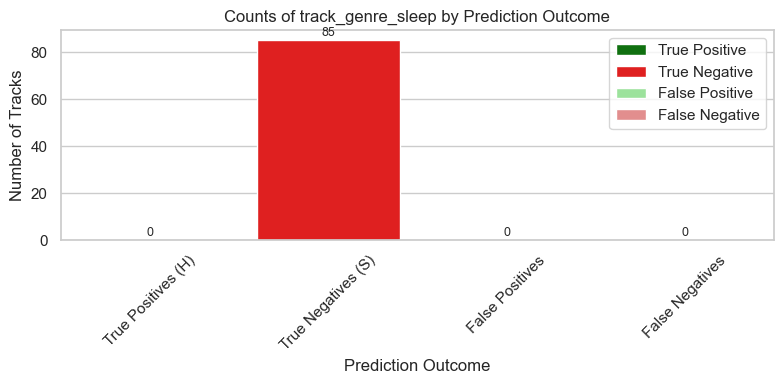

True Positives (H)     0
True Negatives (S)    85
False Positives        0
False Negatives        0
Name: track_genre_sleep, dtype: int64


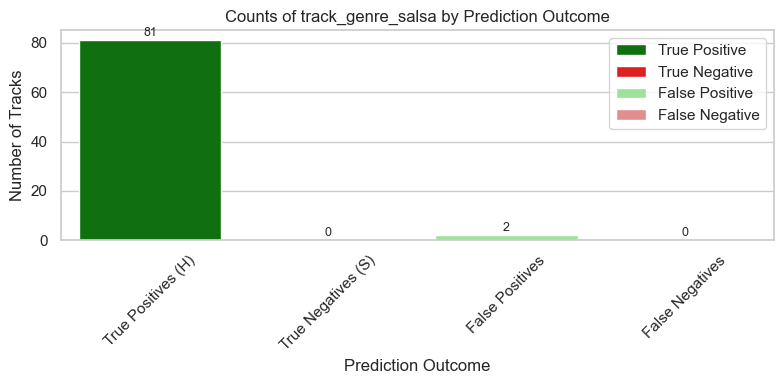

True Positives (H)    81
True Negatives (S)     0
False Positives        2
False Negatives        0
Name: track_genre_salsa, dtype: int64


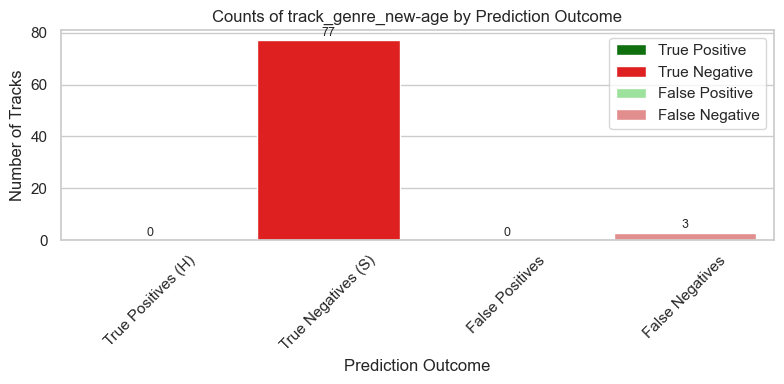

True Positives (H)     0
True Negatives (S)    77
False Positives        0
False Negatives        3
Name: track_genre_new-age, dtype: int64


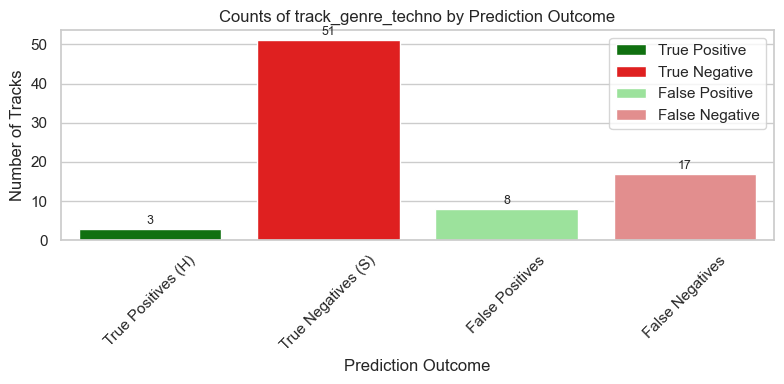

True Positives (H)     3
True Negatives (S)    51
False Positives        8
False Negatives       17
Name: track_genre_techno, dtype: int64


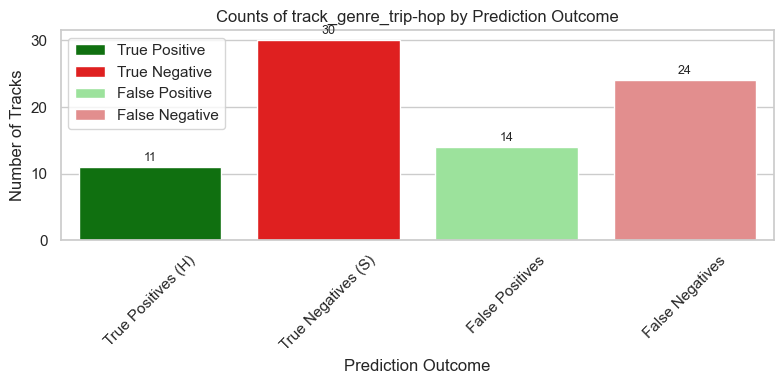

True Positives (H)    11
True Negatives (S)    30
False Positives       14
False Negatives       24
Name: track_genre_trip-hop, dtype: int64


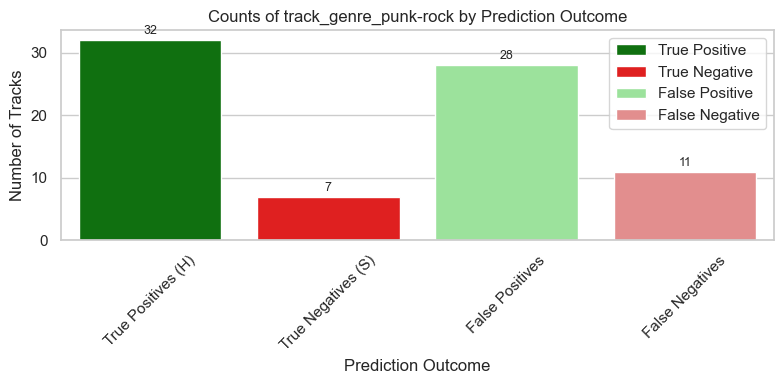

True Positives (H)    32
True Negatives (S)     7
False Positives       28
False Negatives       11
Name: track_genre_punk-rock, dtype: int64


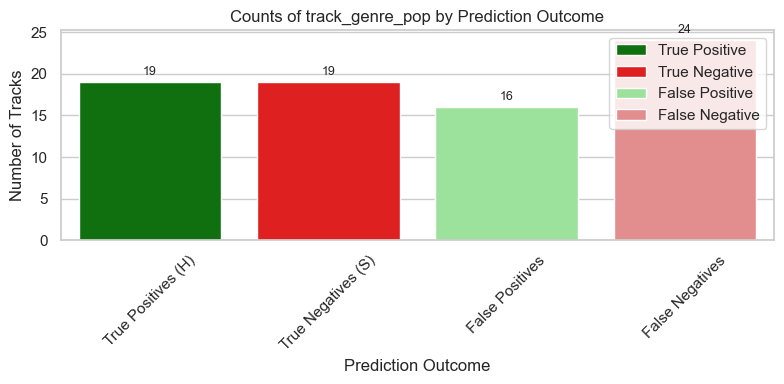

True Positives (H)    19
True Negatives (S)    19
False Positives       16
False Negatives       24
Name: track_genre_pop, dtype: int64


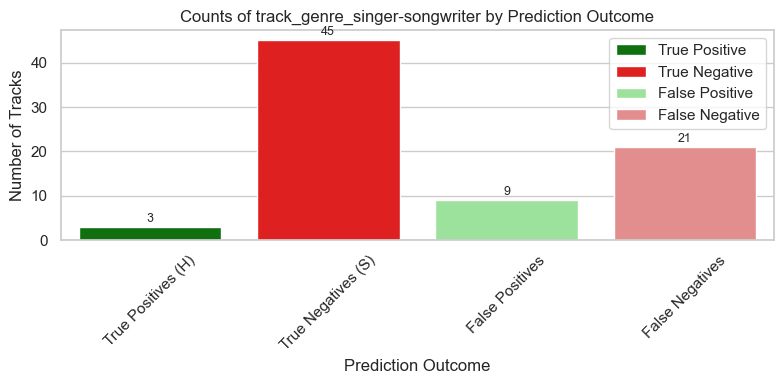

True Positives (H)     3
True Negatives (S)    45
False Positives        9
False Negatives       21
Name: track_genre_singer-songwriter, dtype: int64


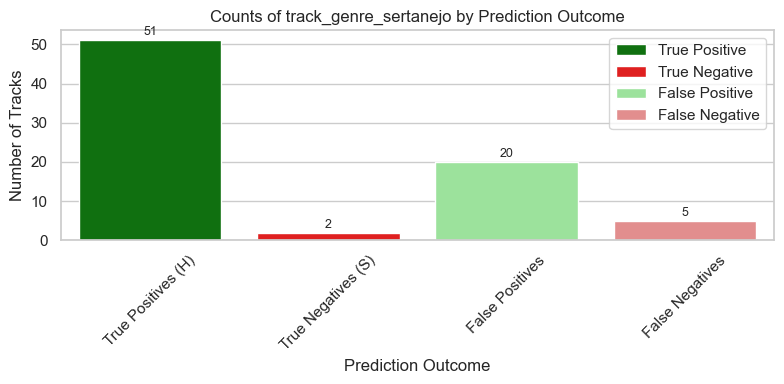

True Positives (H)    51
True Negatives (S)     2
False Positives       20
False Negatives        5
Name: track_genre_sertanejo, dtype: int64


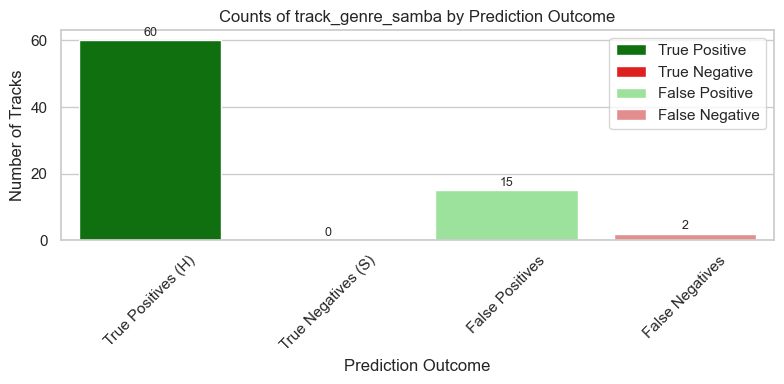

True Positives (H)    60
True Negatives (S)     0
False Positives       15
False Negatives        2
Name: track_genre_samba, dtype: int64


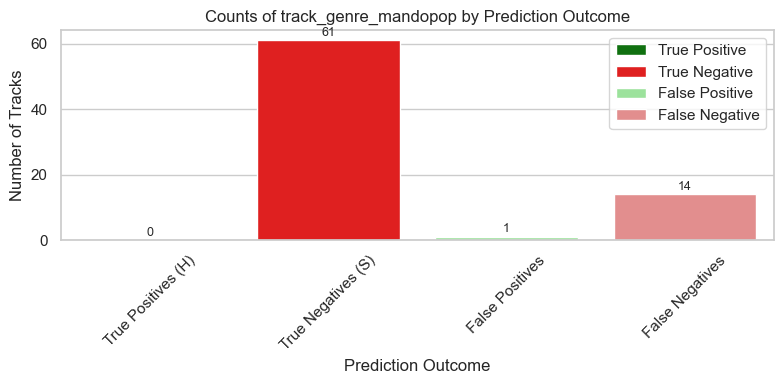

True Positives (H)     0
True Negatives (S)    61
False Positives        1
False Negatives       14
Name: track_genre_mandopop, dtype: int64


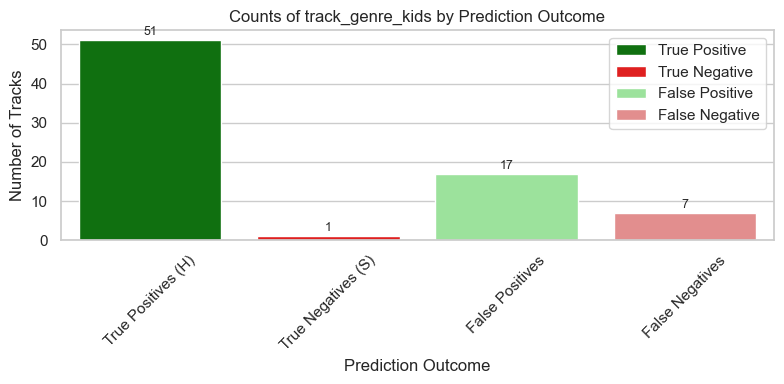

True Positives (H)    51
True Negatives (S)     1
False Positives       17
False Negatives        7
Name: track_genre_kids, dtype: int64


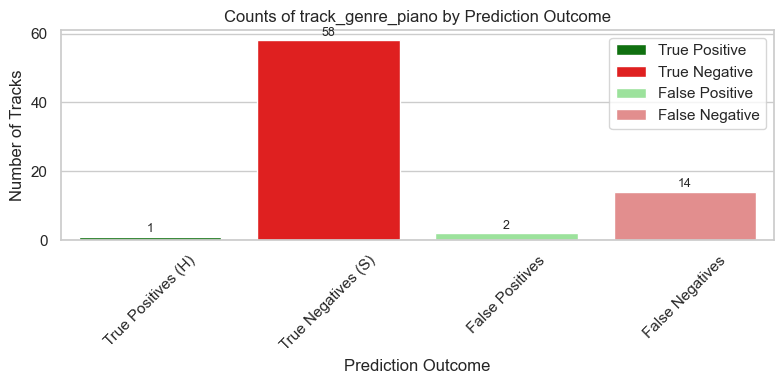

True Positives (H)     1
True Negatives (S)    58
False Positives        2
False Negatives       14
Name: track_genre_piano, dtype: int64


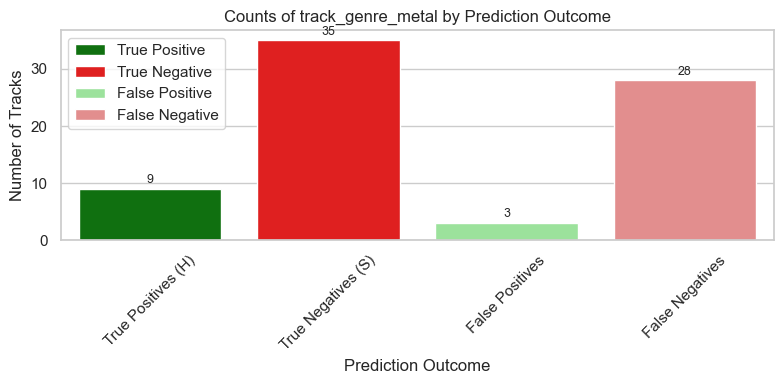

True Positives (H)     9
True Negatives (S)    35
False Positives        3
False Negatives       28
Name: track_genre_metal, dtype: int64


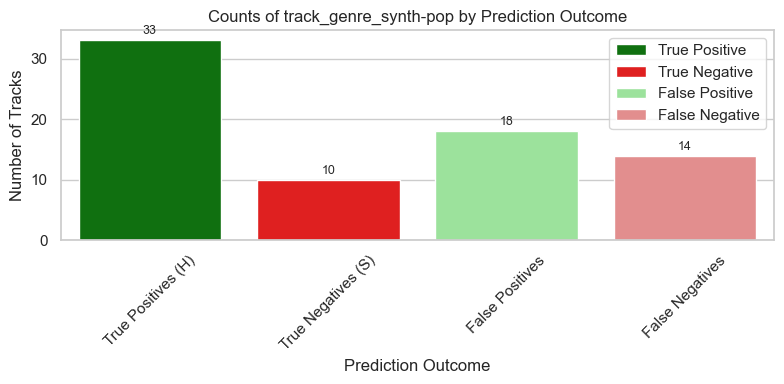

True Positives (H)    33
True Negatives (S)    10
False Positives       18
False Negatives       14
Name: track_genre_synth-pop, dtype: int64


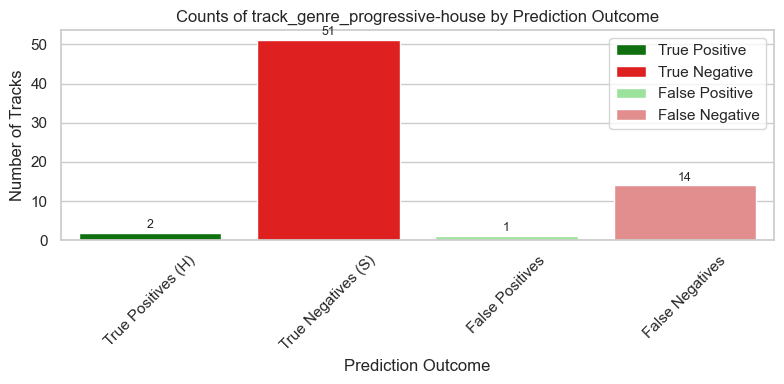

True Positives (H)     2
True Negatives (S)    51
False Positives        1
False Negatives       14
Name: track_genre_progressive-house, dtype: int64


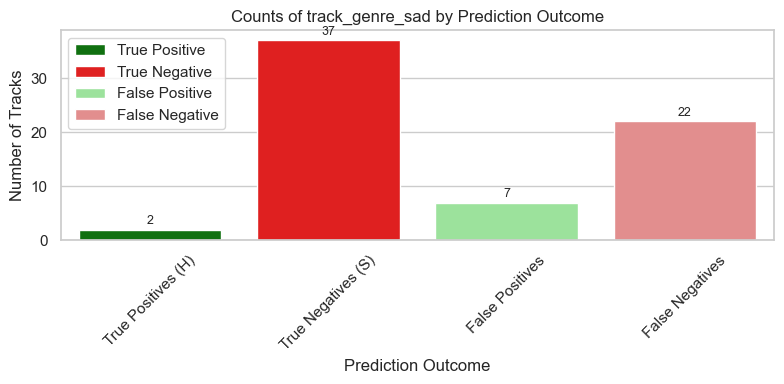

True Positives (H)     2
True Negatives (S)    37
False Positives        7
False Negatives       22
Name: track_genre_sad, dtype: int64


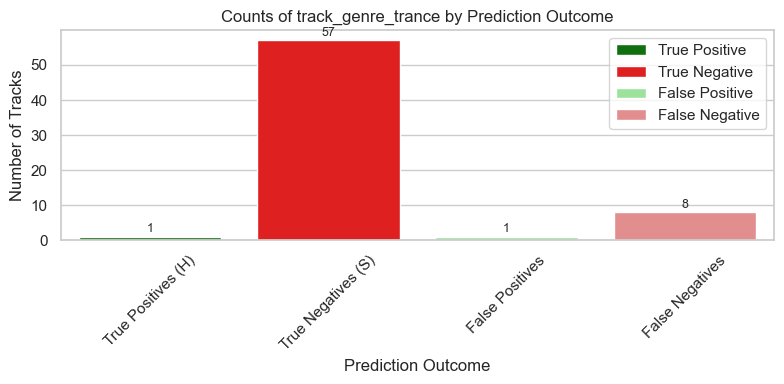

True Positives (H)     1
True Negatives (S)    57
False Positives        1
False Negatives        8
Name: track_genre_trance, dtype: int64


In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Genre Counts per Prediction Outcome ---

# Ensure genre columns are all 0 or 1
genre_cols = [col for col in df.columns if col.startswith("track_genre")]


# Define the prediction outcome groups
groups = {
    "True Positives (H)": true_positives,
    "True Negatives (S)": true_negatives,
    "False Positives": false_positives,
    "False Negatives": false_negatives,
}


# Count genres per group
genre_counts = {
    group_name: (group_df[genre_cols]).astype(int).sum() for group_name, group_df in groups.items()
}


# Create a DataFrame
genre_counts_df = pd.DataFrame(genre_counts).T  # Outcomes as rows
# genre_counts_df.to_csv('output.csv', index=False)


top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).index
# top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).head(20).index


# Plot barplot for each genre
for genre in top_genres:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=genre_counts_df.index,
        y=genre_counts_df[genre].values,
        hue=["True Positive", "True Negative", "False Positive", "False Negative"],
        palette=["green", "red", "lightgreen", "lightcoral"],
    )

    # Add value labels above bars
    for i, value in enumerate(genre_counts_df[genre].values):
        ax.text(i, value + 0.5, str(int(value)), ha="center", va="bottom", fontsize=9)

    plt.title(f"Counts of {genre} by Prediction Outcome")
    plt.ylabel("Number of Tracks")
    plt.xlabel("Prediction Outcome")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(genre_counts_df[genre])

In [ ]:
# Count of genres in true positives
# print(true_negatives.columns.values)
# genre_columns = [col for col in df.columns if col.startswith("track_genre_")]
# print(genre_columns)

# # Step 2: Use idxmax to get the column name with value 1
# df["track_genre"] = df[genre_columns].idxmax(axis=1)

# # Step 3: Remove the "track_genre_" prefix
# df["track_genre"] = df["track_genre"].str.replace("track_genre_", "")

# # Optional: Drop one-hot columns
# df = df.drop(columns=genre_columns)

# mood_counts_by_genre = (
#     df.groupby("track_genre")["valence"].value_counts().unstack().fillna(0)
# )
# true_negatives.to_csv("true_negatives.csv", index=False)

In [ ]:
# Count of genres in true positives
# print(true_negatives.columns.values)
# genre_columns = [col for col in df.columns if col.startswith("track_genre_")]
# print(genre_columns)

# # Step 2: Use idxmax to get the column name with value 1
# df["track_genre"] = df[genre_columns].idxmax(axis=1)

# # Step 3: Remove the "track_genre_" prefix
# df["track_genre"] = df["track_genre"].str.replace("track_genre_", "")

# # Optional: Drop one-hot columns
# df = df.drop(columns=genre_columns)

# mood_counts_by_genre = (
#     df.groupby("track_genre")["valence"].value_counts().unstack().fillna(0)
# )
# true_negatives.to_csv("true_negatives.csv", index=False)

In [ ]:
# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 5)

# # df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# # Features only (adjust as needed)
# feature_cols = [
#     col
#     for col in df.columns
#     if col
#     not in [
#         "target_actual",
#         "target_pred",
#         "track_id",
#         "artists",
#         "album_name",
#         "track_name",
#         "valence",
#     ]
# ]

# print(feature_cols)

# # Mean summary per category
# summary_df = pd.DataFrame(
#     {
#         "False Negatives": false_negatives[feature_cols].mean(),
#         "False Positives": false_positives[feature_cols].mean(),
#         "True Positives": true_positives[feature_cols].mean(),
#         "True Negatives": true_negatives[feature_cols].mean(),
#         # "All Data": df[feature_cols].mean(),
#     }
# )

# # Transpose for easier plotting
# summary_df = summary_df.T

# # Optional: Normalize columns for radar/spider-style plots
# summary_norm = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())


# # --- Comparison Bar Plot for of each genre  ---
# # Choose top 10 most differing features that are ONLY GENRES (by std deviation across groups)
# top_diff_features = (
#     summary_df.filter(like="track_genre")
#     .std()
#     .sort_values(ascending=False)
#     # .head(10)
#     .index
# )


# for feature in top_diff_features:
#     summary_df[feature].plot(
#         kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
#     )
#     plt.xticks(rotation=45)
#     plt.grid(axis="y")
#     plt.tight_layout()
#     plt.show()

# # --- Radar Plot (optional, fancier) ---
# try:
#     from math import pi

#     categories = list(summary_norm.columns)
#     groups = summary_norm.index

#     for group in groups:
#         values = summary_norm.loc[group].tolist()
#         values += values[:1]  # repeat the first value to close the circle

#         angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
#         angles += angles[:1]

#         plt.figure(figsize=(6, 6))
#         ax = plt.subplot(111, polar=True)
#         plt.xticks(angles[:-1], categories, color="grey", size=8)

#         ax.plot(angles, values, linewidth=2, linestyle="solid", label=group)
#         ax.fill(angles, values, alpha=0.2)

#         plt.title(f"Radar Plot for {group}", size=14, y=1.1)
#         plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
#         plt.tight_layout()
#         plt.show()
# except ImportError:
#     print("Radar plot skipped (requires polar plotting support).")

Using K-Nearest Neighbors with audio features to predict song valence, our model achieved a classification accuracy of 73.6%. The model performs slightly better at identifying low-valence (sadder) songs, with higher recall (79%) compared to high-valence (happier) songs (67%). Precision is fairly balanced across both classes. The findings suggest that features like danceability, energy, and acousticness have predictive value for estimating a song’s mood, but future work could explore better handling of class imbalance or using more sophisticated models to improve recall for high-valence tracks.